In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
# ML
import torch
import torch.nn as nn
from sklearn import datasets

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.patches import Circle, Wedge, Polygon

# Math
import math
from math import cos, sin
import numpy as np
import random

## 1 Neural Network

In [3]:
def train(x, y, model, crit):
    for epoch in range(1000):
        y_pred = model(x)
        
        loss = crit(y_pred,y)
        # print('epoch: ', epoch,' loss: ', loss.item())
        optimizer.zero_grad()
        loss.backward()  # back pass
        optimizer.step() # update params
    return loss

In [4]:
def pred(model,x):
    return model(torch.FloatTensor(x)).tolist()

def rand_points():
    x_points = np.linspace(0,10,200)
    y_points = np.linspace(0,10,200)
    points = [[x,y] for x in x_points for y in y_points]
    return points

def train_vals(x):
    return ([z[0] for z in x.tolist()],[z[1] for z in x.tolist()])

def plot_regions(x,y,model):
    x_train,y_train = train_vals(x)
    points = rand_points()
    x_map = [x[0] for x in points]
    y_map = [x[1] for x in points]
    preds = pred(model,points)
    
    
    #get colors
    c1 = ['g','b']
    c2 = ['#E2E79F','#FF90FF']
    
    train_map = [c1[int(x[0])] for x in y.tolist()]
    cmap = [c2[0] if x[0] < 0.5 else c2[1] for x in preds]
    #plot points
    print(len(x_map))
    plt.scatter(x_map,y_map,color=cmap)
    plt.scatter(x_train,y_train,color=train_map,marker='o')
    
    plt.xlabel('X1')
    plt.ylabel('X2')
    #show classification regions
    plt.show()

Underparameterize
40000


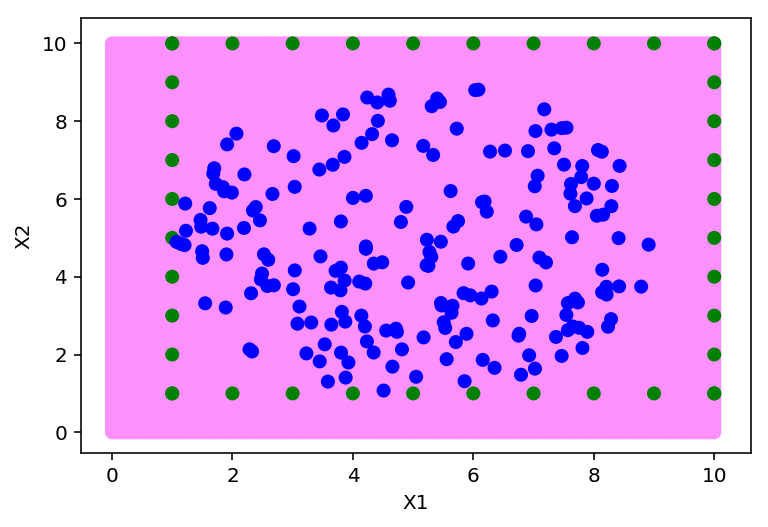

Overparameterize
40000


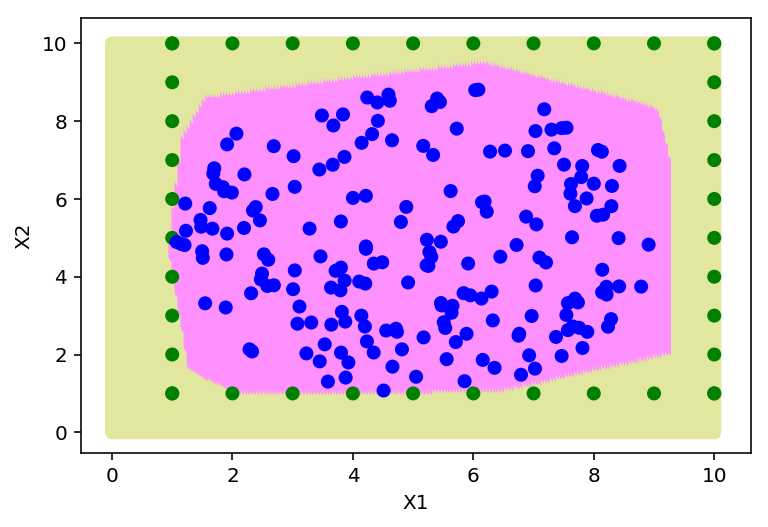

In [5]:
d = 2

#get data for new model
x1 = []
for z in range(1,11):
    x1.append([z,1])
    x1.append((1,z))
    x1.append((10,z))
    x1.append((z,10))
y1 = [[0] for x in range(len(x1))]
x2 = []
y2 = []
for z in range(200):
    r = 4 * (random.random() ** 0.5)
    theta = random.random() * 2 * 3.14159
    x = 5 + r * cos(theta)
    y = 5 + r * sin(theta)
    x2.append([x,y])
    y2.append([1])

x = x1 + x2
y = y1 + y2

x = torch.FloatTensor(x)
y = torch.FloatTensor(y)



print("Underparameterize")
H = 3
model = nn.Sequential(nn.Linear(d,H),
                     nn.ReLU(),
                     nn.Linear(H,1),
                      nn.Sigmoid())

crit = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
    
train(x,y,model,crit)
plot_regions(x,y,model)



print("Overparameterize")
H = 20
model = nn.Sequential(nn.Linear(d,H), # Shape: [2, 20]
                     nn.ReLU(),       # Shape: [20, 20]
                     nn.Linear(H,1),  # Shape: [20, 1]
                      nn.Sigmoid())   # Shape: [1, 1]

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
train(x,y,model,crit)
plot_regions(x,y,model)
    

Underparameterize
40000


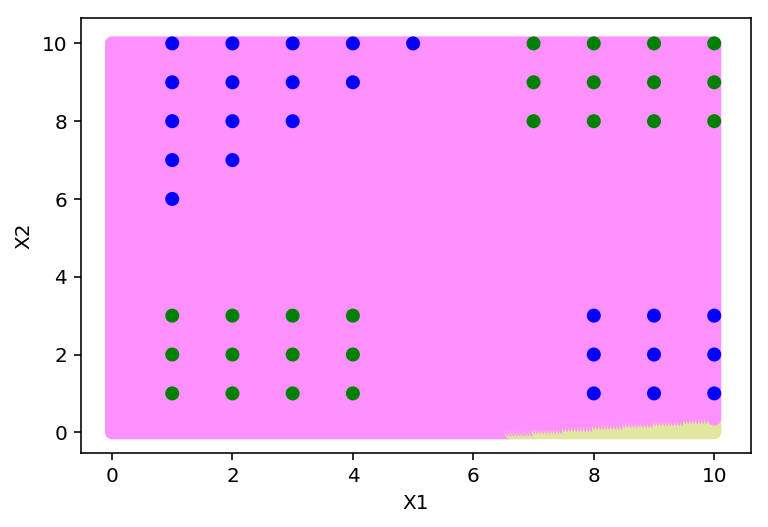

Overparameterize
called
40000


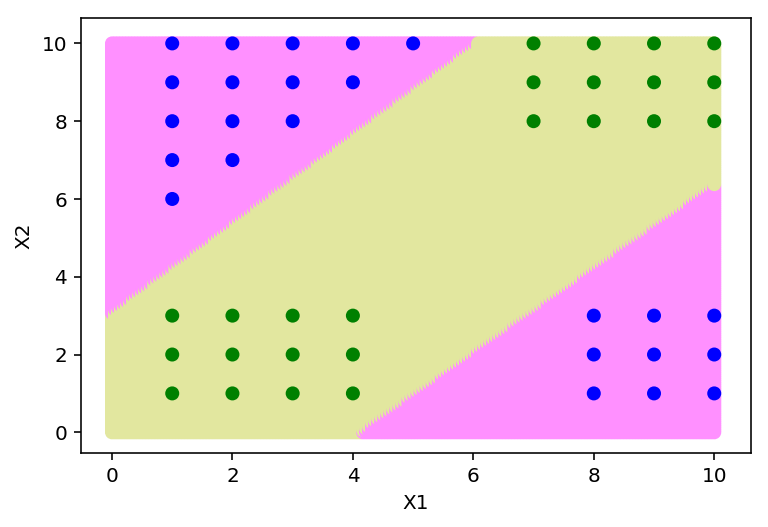

10
[2.91847904e-02 3.71127577e+00 1.75816995e+00 0.00000000e+00
 2.59280717e+00 3.40357983e-04 0.00000000e+00 2.75638464e-03
 4.59409878e+00 1.77932733e+00]


In [6]:

def load_data(file):
    x = []
    y = []
    with open(file) as f:
        for l in f:
            vals = [int(x) for x in l.split()]
            if vals == []:
                break
            x.append([vals[0],vals[1]])
            if vals[2] == 0 or vals[2] == 3:
                y.append([0])
            else:
                y.append([1])
    return x,y

x,y = load_data('data0.txt')
x = torch.FloatTensor(x)
y = torch.FloatTensor(y)

H = 3
print("Underparameterize")
model = nn.Sequential(nn.Linear(d,H),
                     nn.ReLU(),
                     nn.Linear(H,1),
                      nn.Sigmoid())

crit = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
train(x,y,model,crit)
plot_regions(x,y,model)
    

H = 10
print("Overparameterize")

model = nn.Sequential(nn.Linear(d,H),
                     nn.ReLU(),
                     nn.Linear(H,1),
                      nn.Sigmoid())




crit = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
train(x,y,model,crit)

o = []

def hook(module, input, output):
    print("called")
    o.append(output)
    
model[1].register_forward_hook(hook)


plot_regions(x,y,model)

print(len(o[0].tolist()[0]))
a = np.array(o[0].tolist())
t = np.sum(a, axis=0) / a.shape[0]
print(t)

In [7]:
y.shape

torch.Size([48, 1])

In [8]:
y.shape

torch.Size([48, 1])

In [9]:
# Notes

#how many different local optima are found?
#local optima are diff if different classification
# of training data
# decision boundry will be different every time, so it
# is not a  good measure

#also figure out how the weights are spread out
#visualize weights in relation to each other

#4 syntehtic data sets


#NN spread out weights

#look at SGD vs Adam

## 2 Synthetic data set generator

### 2.1 Generate circles and disks

In [10]:
def gen_circle(n, x, y, radius, disk_start=0, circ_start=0, circ_end=1, noise=False):
    """
    Generates points in within a specific disk.
    
    Args:
        - n: Number of points to generate
        - x: X-axis center of circle
        - y: Y-axis center of circle
        - radius:     Radius of circle
        - disk_start: [0, 1] where to start center of circle
        - circ_start: [0, 1] Start place of circle (Defaults 0 == 3PM).
        - circ_end:   [0, 1] End place of circle (Defaults 1 == 3PM, wraps around counter clockwise).
        - noise:      Add standard normal noise to data points
    """
    data = []
    for i in range(n):
        arc = random.uniform(circ_start, circ_end) * 2 * math.pi
        r = radius * np.sqrt(random.uniform(disk_start, 1))
        
        p_x = r * np.cos(arc) + x
        p_y = r * np.sin(arc) + y
        
        if noise:
            p_x += np.random.normal(0,1)
            p_y += np.random.normal(0,1)
            
        data.append([p_x, p_y])
    return data

### 2.2 Visualize two datasets

In [11]:
def plot(data1, data2):
    data1 = np.array(data1)
    data2 = np.array(data2)
    figure(num=None, figsize=(6, 6), dpi=120, facecolor='w', edgecolor='k')
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111, aspect='equal')



    axis = { 'xmin' : -10, 
             'xmax' : 10, 
             'ymin' : -10, 
             'ymax' : 10 }

    #ax2.add_artist(Circle((x, y), r, color=(1,0,0,.7)))
    plt.axis(**axis)
    plt.scatter(data1[:, 0], data1[:, 1])
    plt.scatter(data2[:, 0], data2[:, 1])
    plt.show()

## 3 Neural net visualization

### 3.1 Neural net hidden layer weight plot function

In [12]:

def show_weights(model):
    weights1 = np.array(model[0].weight.tolist())
    weights2 = np.array(model[2].weight.tolist())[0]
    print(weights1)
    #bias = np.array(model[-1].bias.tolist())
    
    figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

    plt.scatter(weights1[:,0], weights1[:,1], s=300, color='salmon', edgecolor='black', linewidths=2)
    
    m = np.max(np.abs(weights1))
    pad = .1 * m
    plt.xlim(-m - pad, m + pad)
    plt.ylim(-m - pad, m + pad)
    plt.title('Counts of Feature Variable Types')
    plt.xlabel('w1')
    plt.ylabel('w2')

    #plt.savefig('Var-Type-Bar.png')

    plt.show()
    
    plt.bar(list(range(len(weights2))), weights2)
    plt.show()
    
def show_layer(outputs):
    print(np.shape(outputs))
    plt.bar(list(range(len(outputs))), outputs)
    plt.show()

    
    
def test_set():
    x_points = np.linspace(0,10,200)
    y_points = np.linspace(0,10,200)
    points = [[x,y] for x in x_points for y in y_points]
    return points



def do_all(x,y,H):
    for ind in range(1):
        print('---------------------------------------------------------------')
        model = nn.Sequential(nn.Linear(d,H),
                             nn.ReLU(),
                             nn.Linear(H,1),
                              nn.Sigmoid())

        crit = torch.nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
        loss = train(x,y,model,crit)
        print("The loss is " + str(loss.tolist()))

        o = []

        def hook(module, input, output):
            o.append(output)

        model[1].register_forward_hook(hook)

        plot_regions(x,y,model)
        show_weights(model)
        a = np.array(o[0].tolist())
        t = np.sum(a, axis=0) / a.shape[0]




        #plot_regions(x,y,model)
        #show_weights(model)
        show_layer(t)
        print('---------------------------------------------------------------')

## Data set 1

<Figure size 720x720 with 0 Axes>

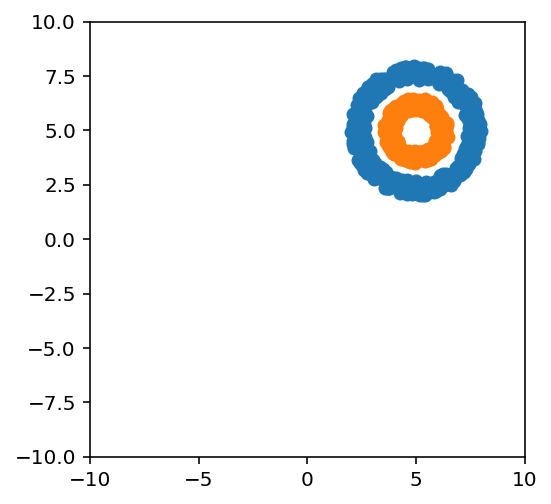

700
700


In [13]:
n = 250
r = 3
x = 5
y = 5

data1 = gen_circle(350, x, y, r, disk_start = .6, circ_start = 0 , circ_end = 1)
data2 = gen_circle(350, x, y, 1.5, disk_start = .4, circ_start = 0 , circ_end = 1)

plot(data1, data2)

x = torch.FloatTensor(data1 + data2)
y = ([[0]] * len(data1)) + ([[1]] * len(data2))
y = torch.FloatTensor(y)
print(len(x))
print(len(y))

The loss is 0.012943349778652191
40000


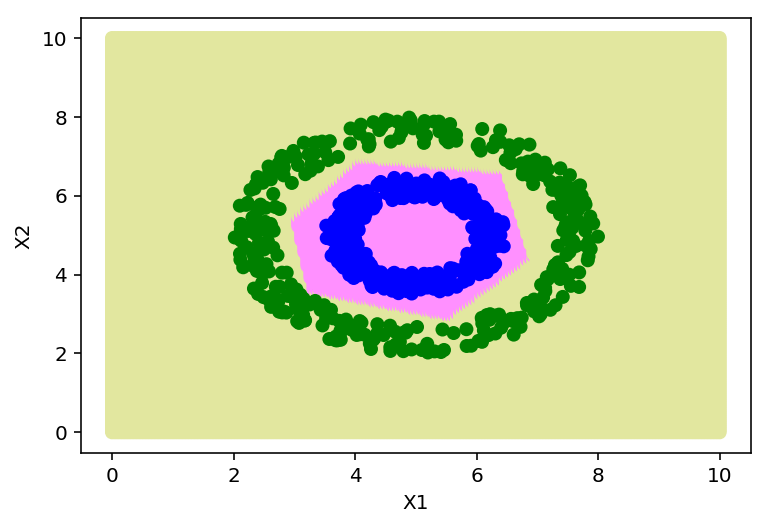

[[ 1.39576089  0.51558888]
 [-1.9515152   2.04322696]
 [-0.3153007  -1.2528609 ]
 [-0.01366753 -0.11191611]
 [ 0.76506174  1.34626353]
 [-0.33162454 -0.49545211]
 [-0.34438789 -0.04709452]
 [ 0.40912315 -0.38413379]
 [-0.44829267 -0.40252843]
 [-0.5992077   0.2426725 ]]


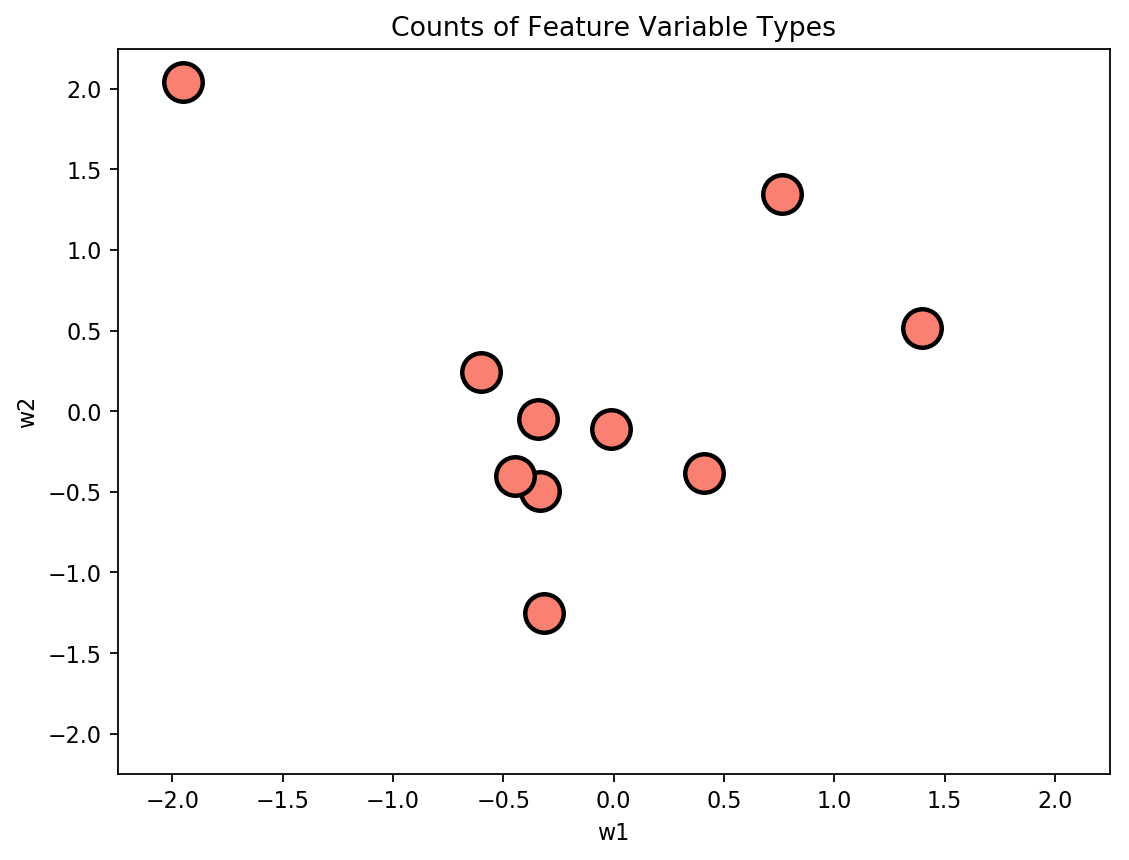

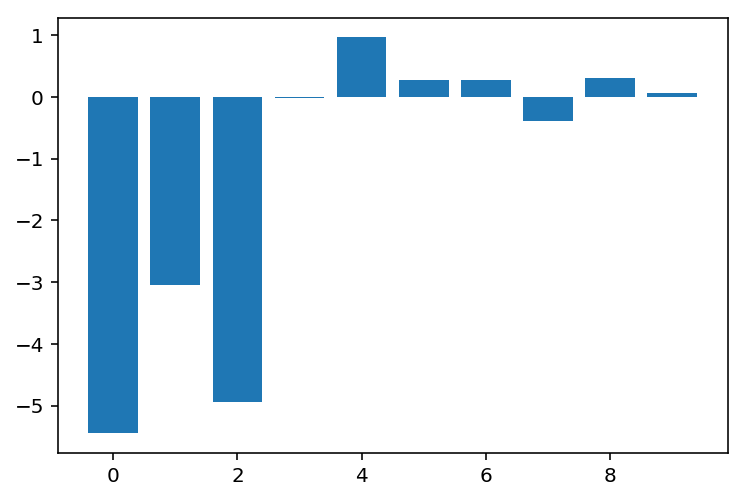

(10,)


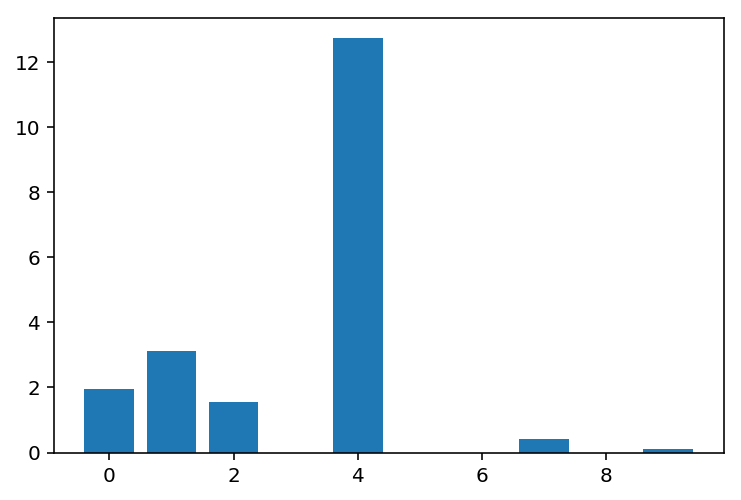

The loss is 0.018559454008936882
40000


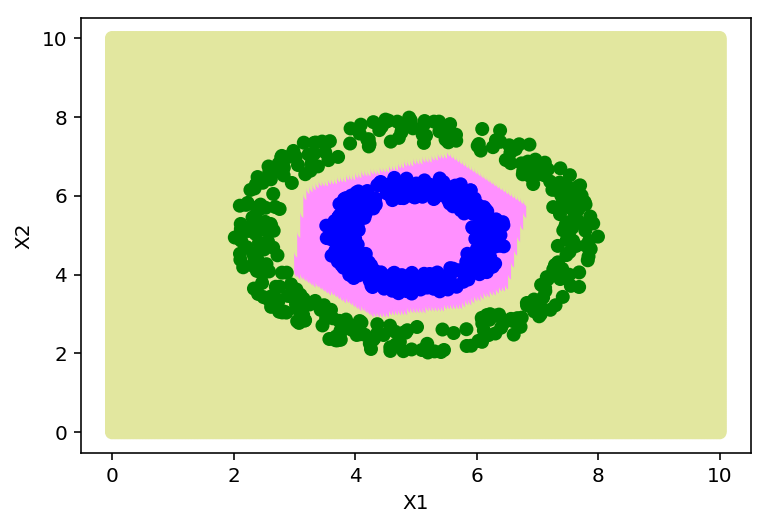

[[ 2.05088711 -1.84880161]
 [-0.50872856 -0.21662739]
 [ 0.49133655  1.54608774]
 [ 0.05605308 -0.55236453]
 [-0.83883923 -0.65029687]
 [ 0.28119349  1.03739536]
 [ 0.309522   -0.64814037]
 [-2.1365521   1.83603048]
 [-0.19672865 -0.45826471]
 [ 0.89800489  1.25382769]]


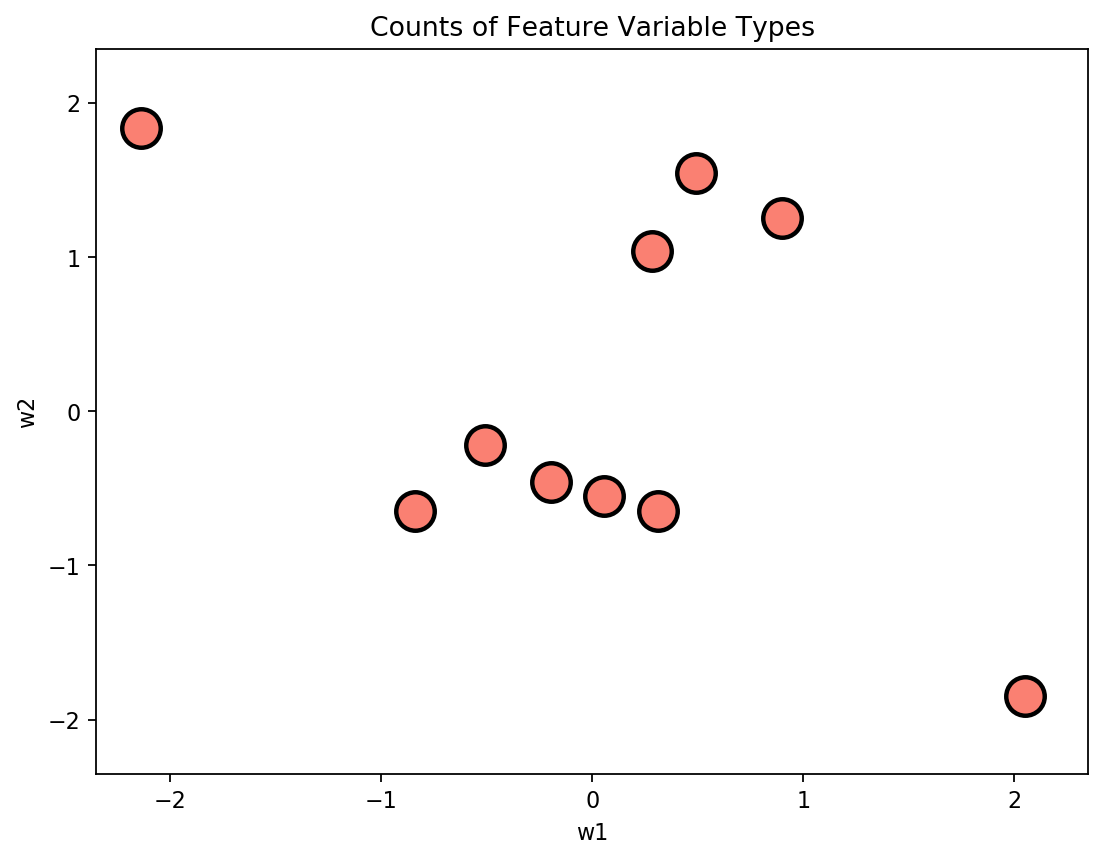

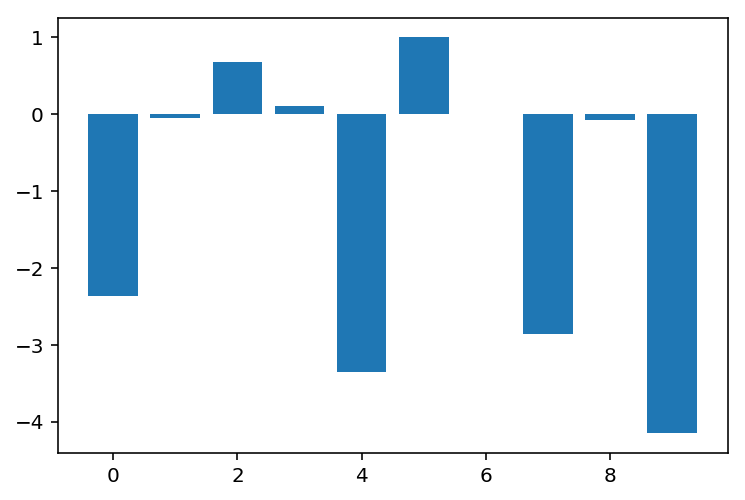

(10,)


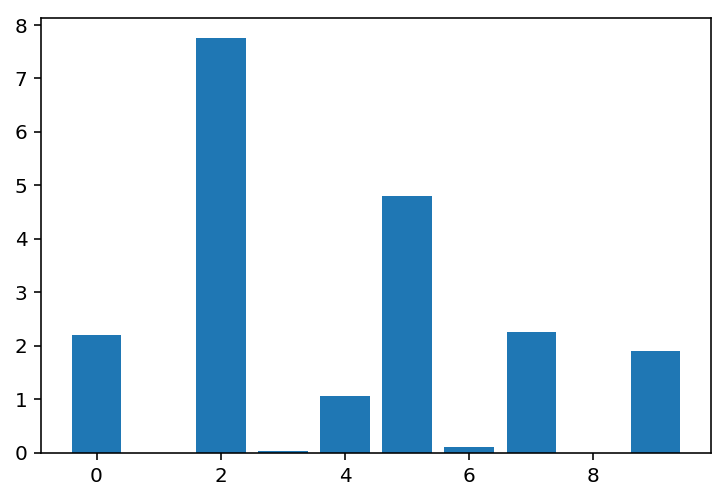

The loss is 0.4083302915096283
40000


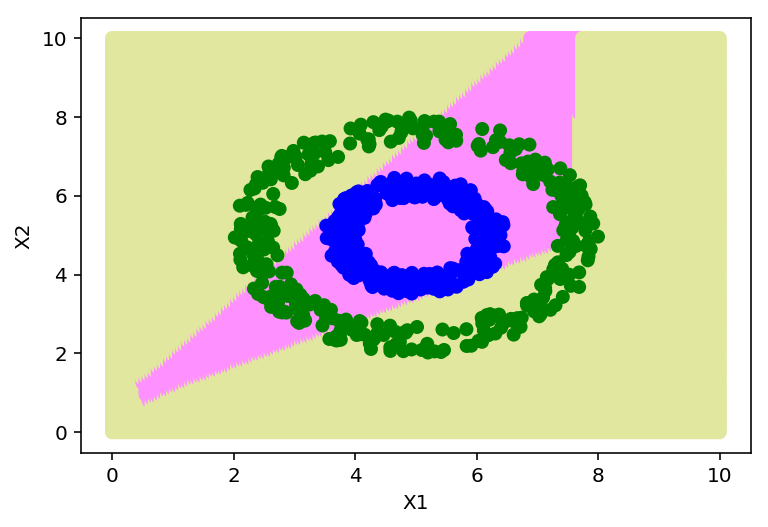

[[ 0.17005266  0.04519852]
 [-1.46414542  2.90187621]
 [ 2.40269089 -1.6504519 ]
 [-0.40136451  0.24552578]
 [-0.67634016 -0.09794176]
 [-0.5931235  -0.32656929]
 [ 2.3913517   0.46861413]
 [ 0.840554    0.37008771]
 [-0.22684175 -0.552145  ]
 [-0.6963293  -0.18072164]]


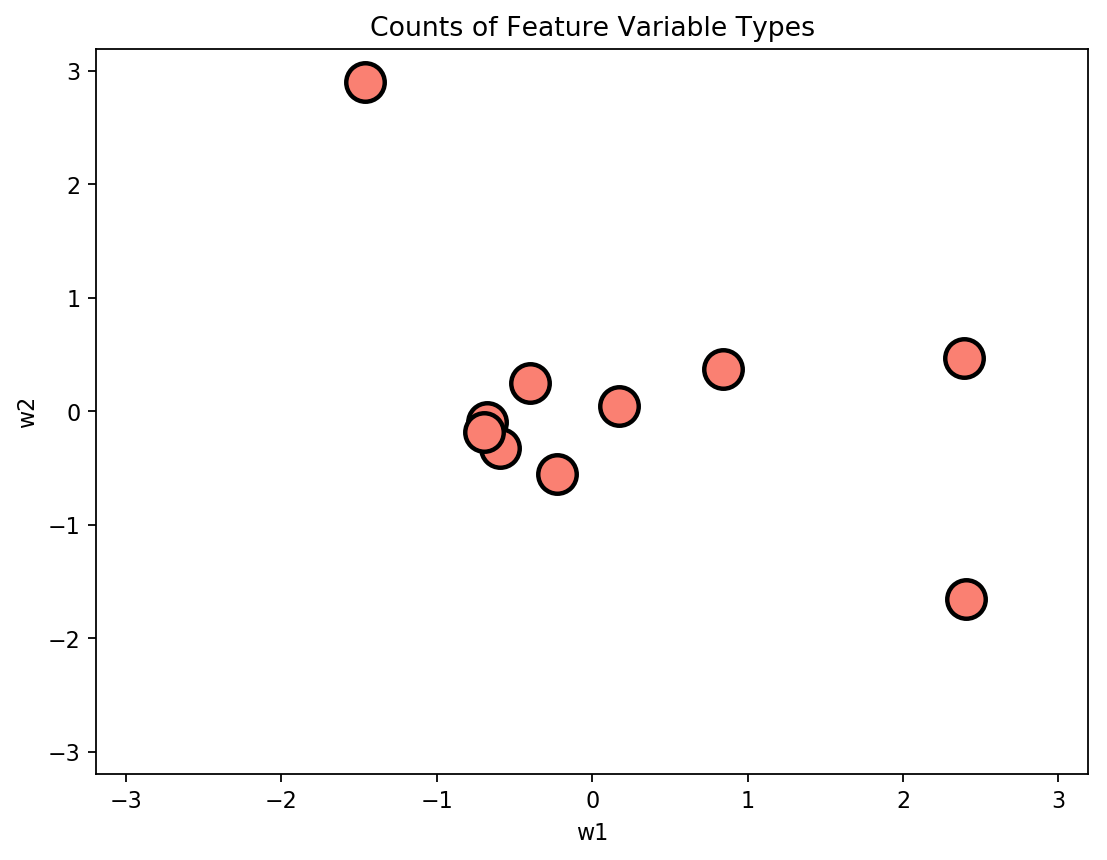

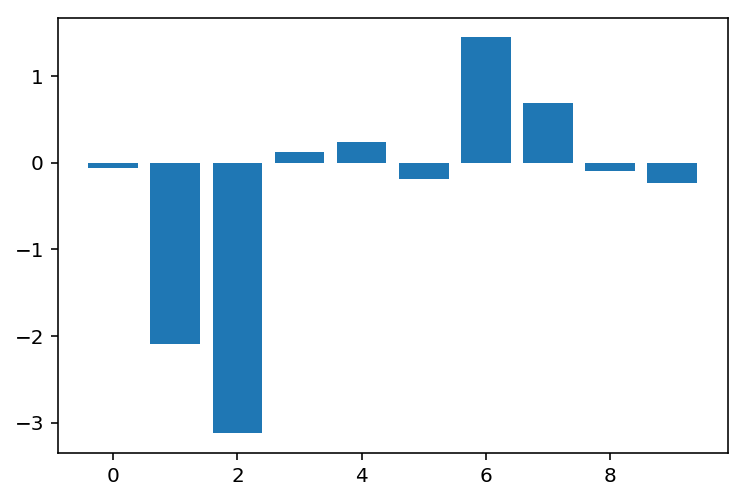

(10,)


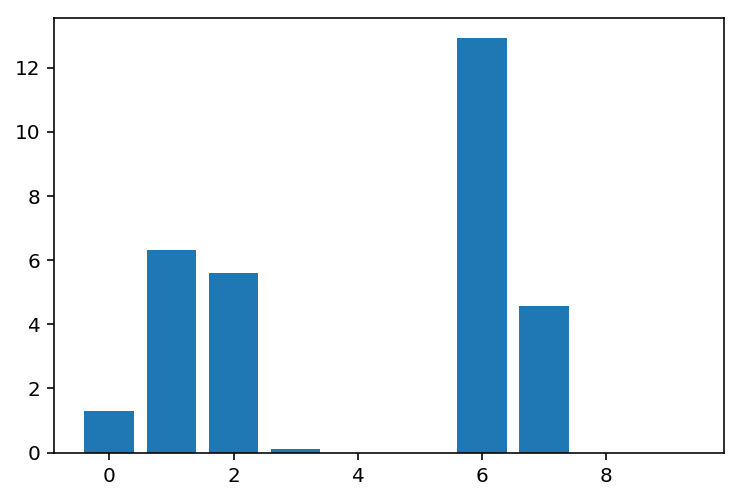

In [14]:
for ind in range(3):

    H = 10
    model = nn.Sequential(nn.Linear(d,H),
                         nn.ReLU(),
                         nn.Linear(H,1),
                          nn.Sigmoid())

    crit = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
    loss = train(x,y,model,crit)
    print("The loss is " + str(loss.tolist()))
    
    o = []

    def hook(module, input, output):
        o.append(output)
    
    model[1].register_forward_hook(hook)
    
    plot_regions(x,y,model)
    show_weights(model)
    a = np.array(o[0].tolist())
    t = np.sum(a, axis=0) / a.shape[0]
    show_layer(t)
    
    


## Data set 2

<Figure size 720x720 with 0 Axes>

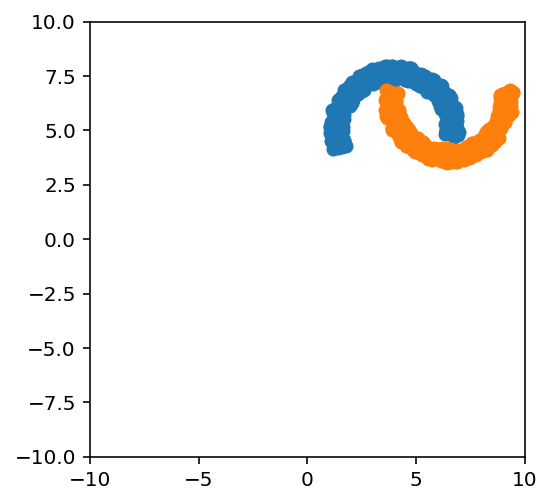

800
800


In [15]:
n = 250
r = 3
x = 5
y = 5

data5 = gen_circle(400, x - 1, y, r, disk_start = .6, circ_start = -.02 , circ_end = .55)
data6 = gen_circle(400, x + 1.5, y + 1.5, r, disk_start = .6, circ_start = .48 , circ_end = 1.02)

plot(data5, data6)

x = torch.FloatTensor(data5 + data6)
y = ([[0]] * len(data5)) + ([[1]] * len(data6))
y = torch.FloatTensor(y)
print(len(x))
print(len(y))

The loss is 0.2995903491973877
40000


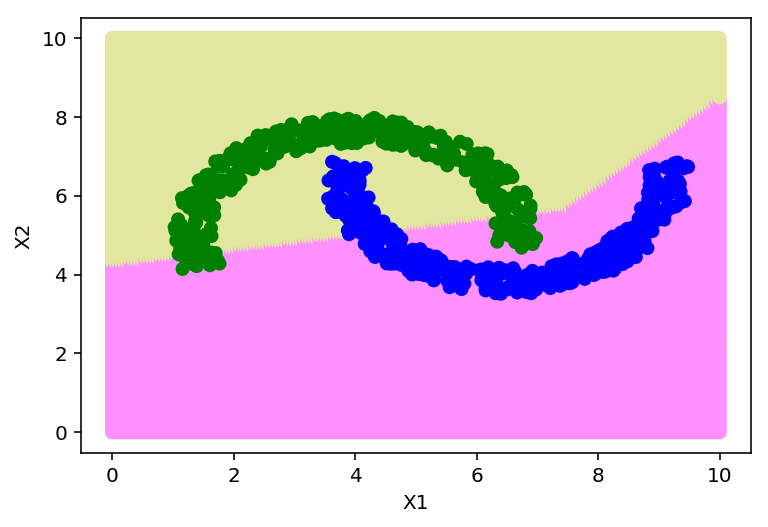

[[ 7.93541849e-01 -1.45997727e+00]
 [ 2.43760541e-01  5.06597102e-01]
 [-2.63943255e-01 -1.31264493e-01]
 [ 1.41128814e+00 -1.08681941e+00]
 [-4.88062084e-01 -1.96279705e-01]
 [ 1.13355017e+00 -7.65523136e-01]
 [-3.98265958e-01 -2.24551141e-01]
 [-6.28222525e-01 -2.97317266e-01]
 [-4.22937632e-01 -7.80847669e-02]
 [ 4.56814408e-01 -3.71936738e-01]
 [-3.58379632e-01 -1.25943661e-01]
 [ 5.09835780e-01  5.06624937e-01]
 [-5.49565375e-01 -2.32433707e-01]
 [ 5.15115201e-01 -1.78800523e-01]
 [-3.74541759e-01 -6.12735689e-01]
 [ 2.35538825e-01 -1.58507615e-01]
 [ 3.68977457e-01 -6.60876215e-01]
 [ 3.10685128e-01  3.21862251e-01]
 [ 3.85463238e-04 -4.27932441e-01]
 [ 6.06359720e-01 -9.73376781e-02]
 [-6.81963384e-01 -6.34029210e-01]
 [ 4.47212726e-01  1.98967963e-01]
 [-5.29183626e-01  7.85362720e-02]
 [ 3.95351231e-01 -3.94068301e-01]
 [ 4.24657948e-02  8.94479156e-01]]


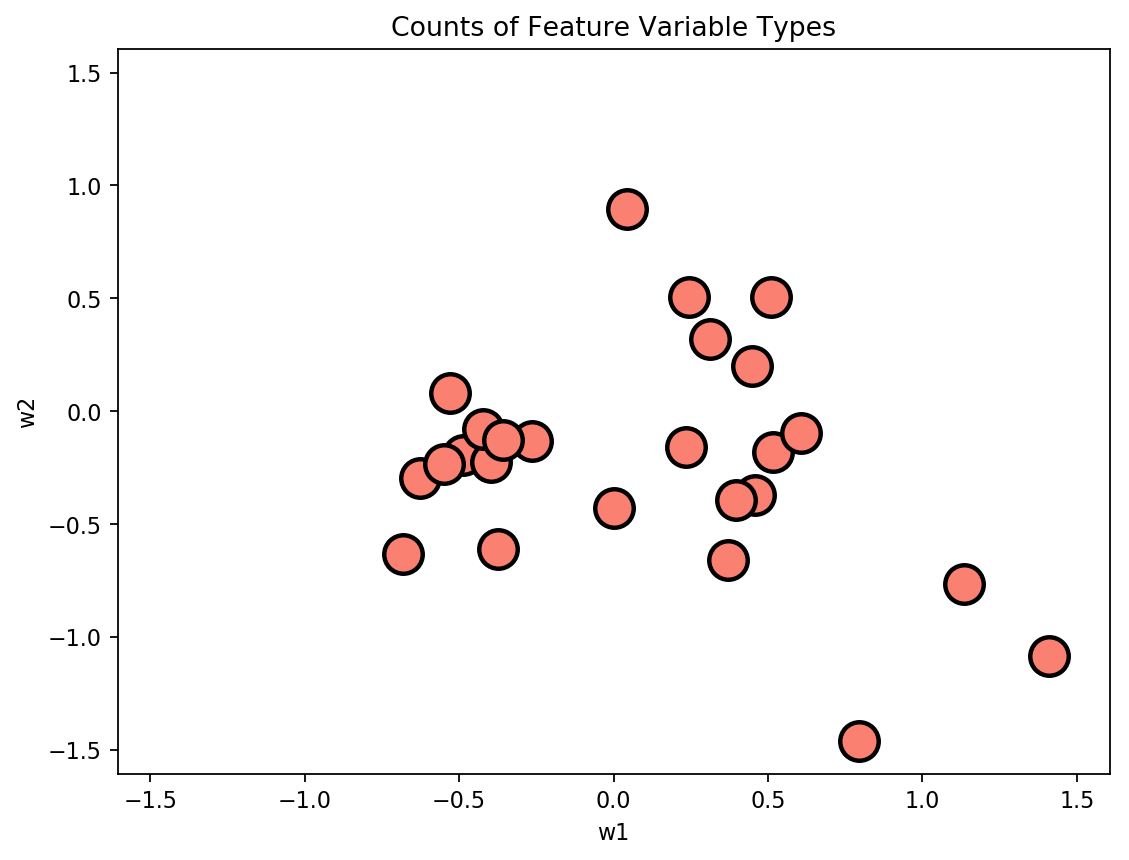

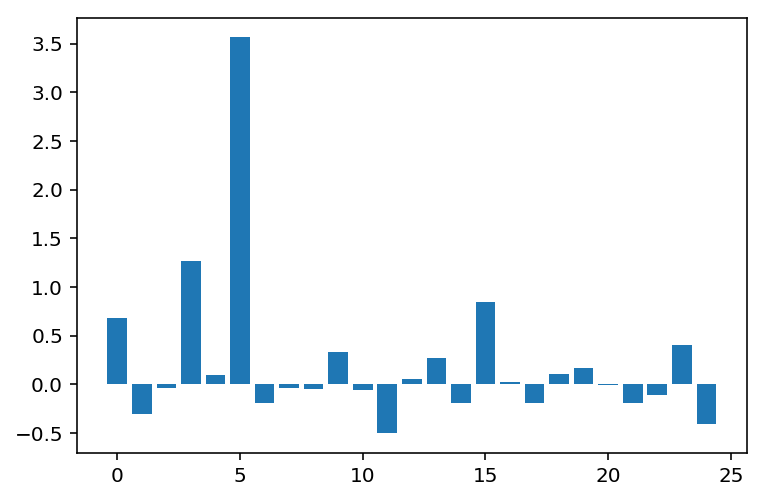

40000


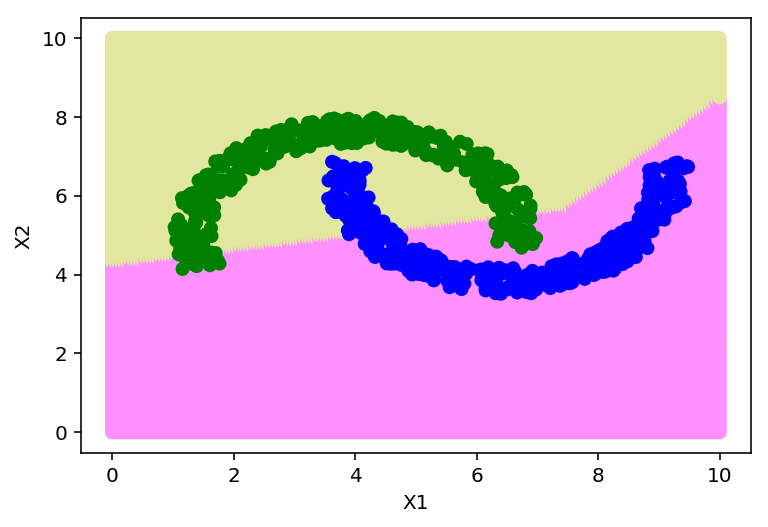

[[ 7.93541849e-01 -1.45997727e+00]
 [ 2.43760541e-01  5.06597102e-01]
 [-2.63943255e-01 -1.31264493e-01]
 [ 1.41128814e+00 -1.08681941e+00]
 [-4.88062084e-01 -1.96279705e-01]
 [ 1.13355017e+00 -7.65523136e-01]
 [-3.98265958e-01 -2.24551141e-01]
 [-6.28222525e-01 -2.97317266e-01]
 [-4.22937632e-01 -7.80847669e-02]
 [ 4.56814408e-01 -3.71936738e-01]
 [-3.58379632e-01 -1.25943661e-01]
 [ 5.09835780e-01  5.06624937e-01]
 [-5.49565375e-01 -2.32433707e-01]
 [ 5.15115201e-01 -1.78800523e-01]
 [-3.74541759e-01 -6.12735689e-01]
 [ 2.35538825e-01 -1.58507615e-01]
 [ 3.68977457e-01 -6.60876215e-01]
 [ 3.10685128e-01  3.21862251e-01]
 [ 3.85463238e-04 -4.27932441e-01]
 [ 6.06359720e-01 -9.73376781e-02]
 [-6.81963384e-01 -6.34029210e-01]
 [ 4.47212726e-01  1.98967963e-01]
 [-5.29183626e-01  7.85362720e-02]
 [ 3.95351231e-01 -3.94068301e-01]
 [ 4.24657948e-02  8.94479156e-01]]


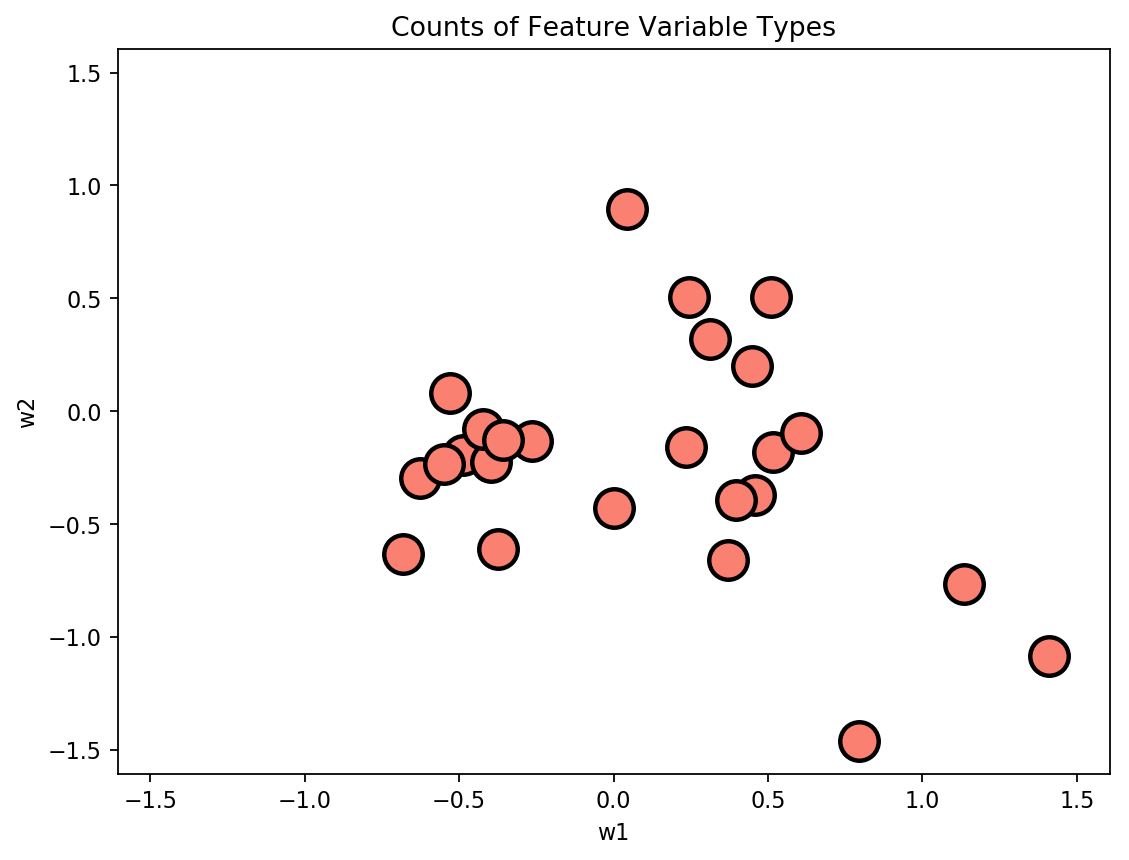

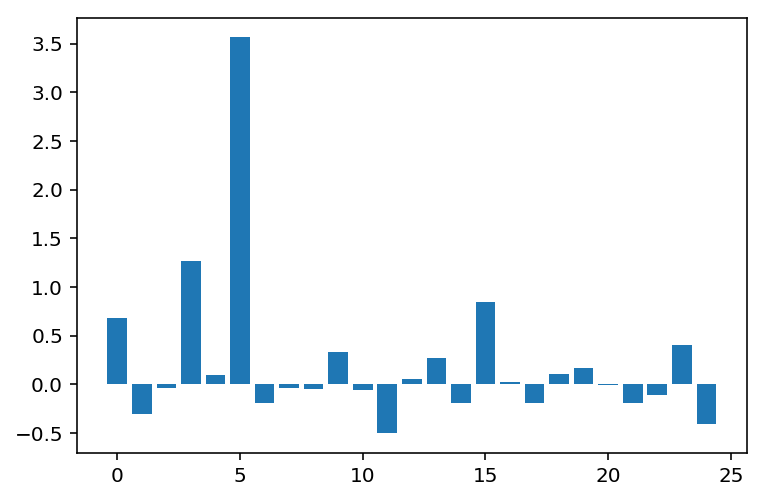

(25,)


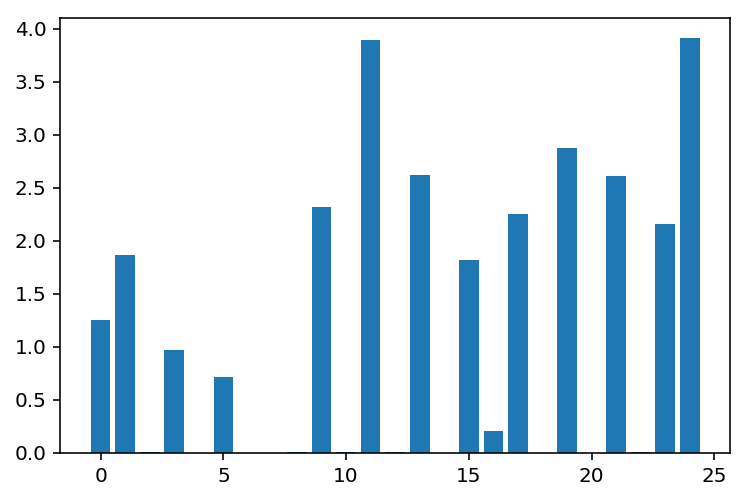

The loss is 0.34138762950897217
40000


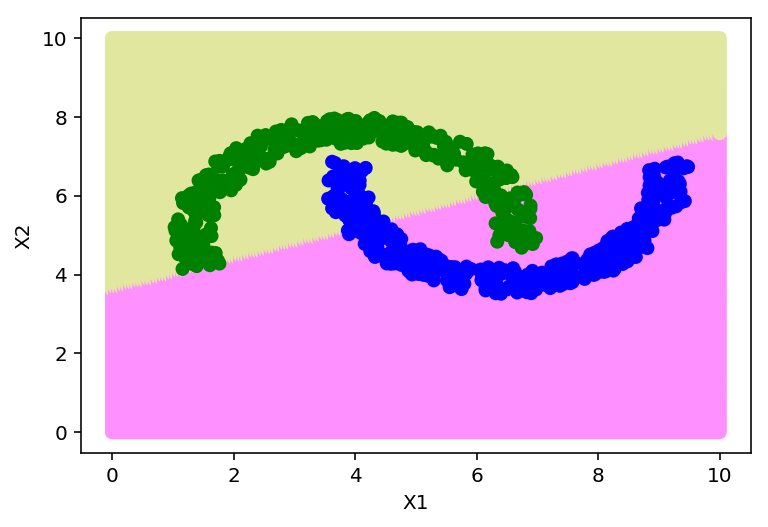

[[ 0.75564843  0.20212646]
 [-0.01191523  0.43506941]
 [ 0.42342183 -0.76299477]
 [-0.3779768  -0.55546534]
 [-0.11968802  0.72537106]
 [-0.79099733  0.03759006]
 [-0.51111853 -0.47278267]
 [ 0.0521279  -0.57817543]
 [-0.66639376  0.11404313]
 [-0.31653413 -0.23551852]
 [ 0.16666567  0.94030195]
 [ 0.07256234  0.66157359]
 [-0.03197096  0.36915466]
 [ 0.33958641 -0.25943103]
 [-0.08538643  0.03504506]
 [-0.74979627  0.08106082]
 [-0.22654587 -0.20182091]
 [-0.10772324 -0.45160919]
 [ 0.28933075  0.03691198]
 [-0.51447916 -0.67858201]
 [ 0.38196218  0.39253303]
 [-0.58372569 -0.29966038]
 [-0.26661202 -0.1359868 ]
 [ 0.10985135  0.51321149]
 [-0.26827034  0.93397218]]


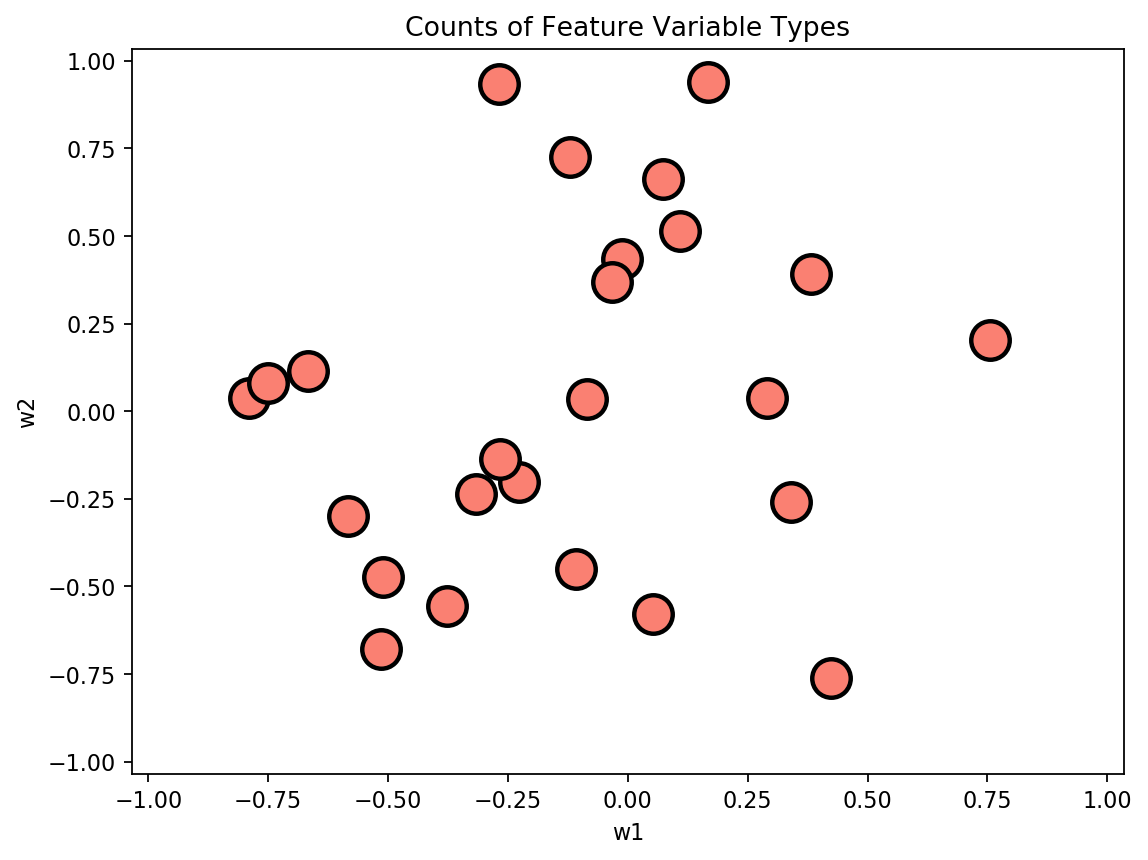

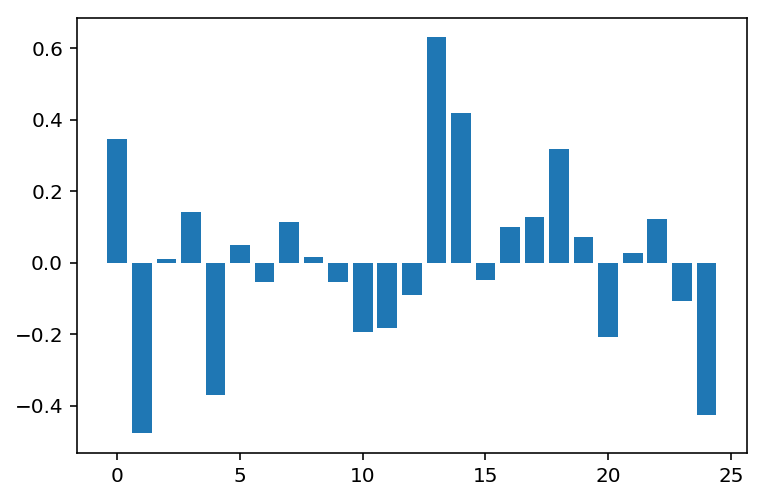

40000


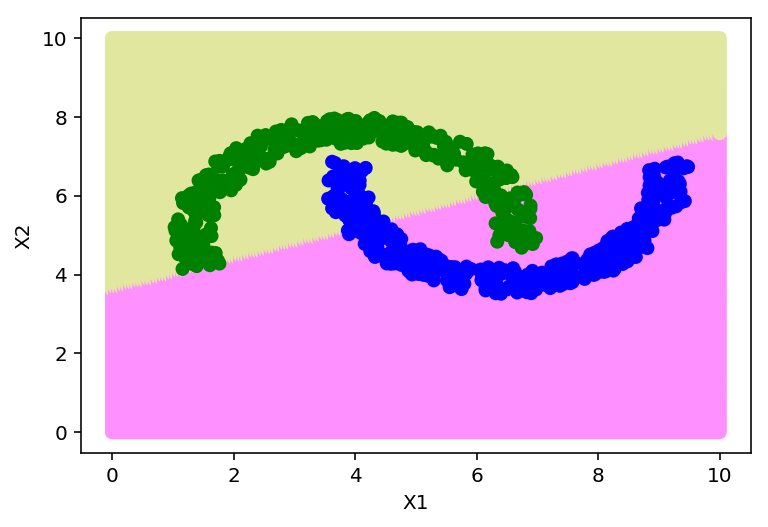

[[ 0.75564843  0.20212646]
 [-0.01191523  0.43506941]
 [ 0.42342183 -0.76299477]
 [-0.3779768  -0.55546534]
 [-0.11968802  0.72537106]
 [-0.79099733  0.03759006]
 [-0.51111853 -0.47278267]
 [ 0.0521279  -0.57817543]
 [-0.66639376  0.11404313]
 [-0.31653413 -0.23551852]
 [ 0.16666567  0.94030195]
 [ 0.07256234  0.66157359]
 [-0.03197096  0.36915466]
 [ 0.33958641 -0.25943103]
 [-0.08538643  0.03504506]
 [-0.74979627  0.08106082]
 [-0.22654587 -0.20182091]
 [-0.10772324 -0.45160919]
 [ 0.28933075  0.03691198]
 [-0.51447916 -0.67858201]
 [ 0.38196218  0.39253303]
 [-0.58372569 -0.29966038]
 [-0.26661202 -0.1359868 ]
 [ 0.10985135  0.51321149]
 [-0.26827034  0.93397218]]


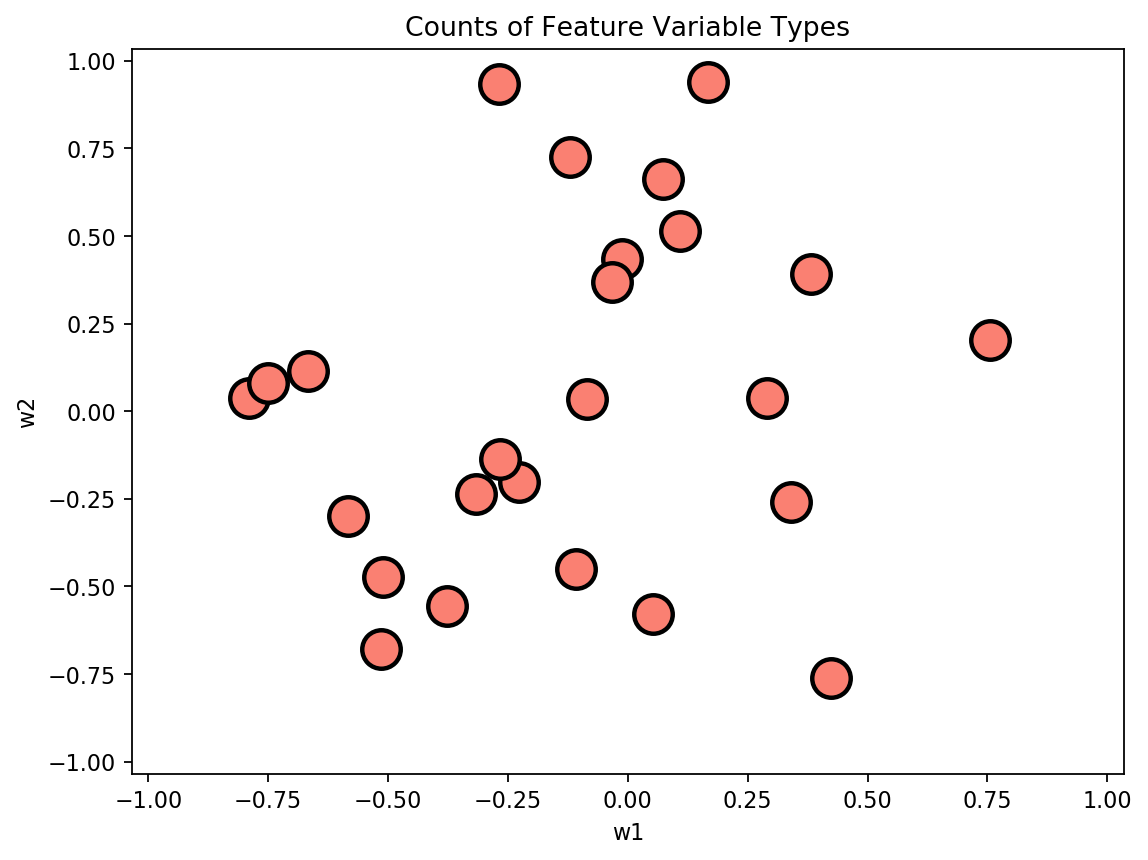

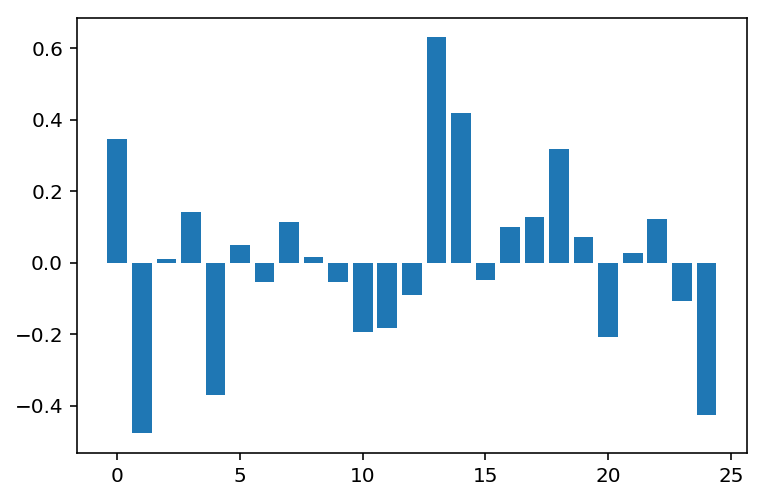

(25,)


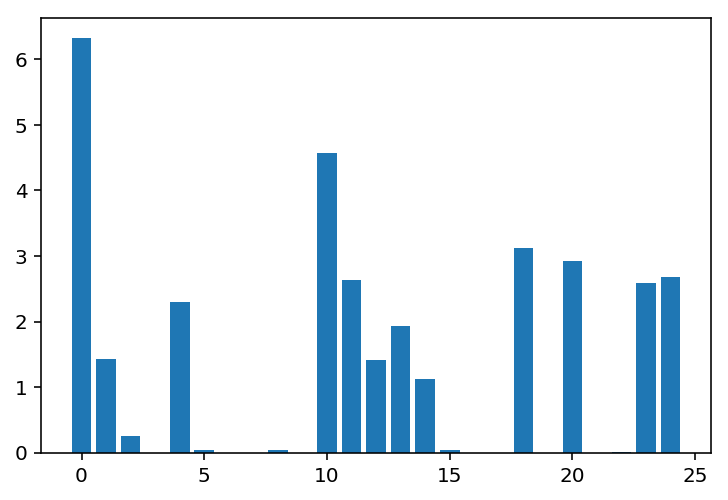

The loss is 0.26976752281188965
40000


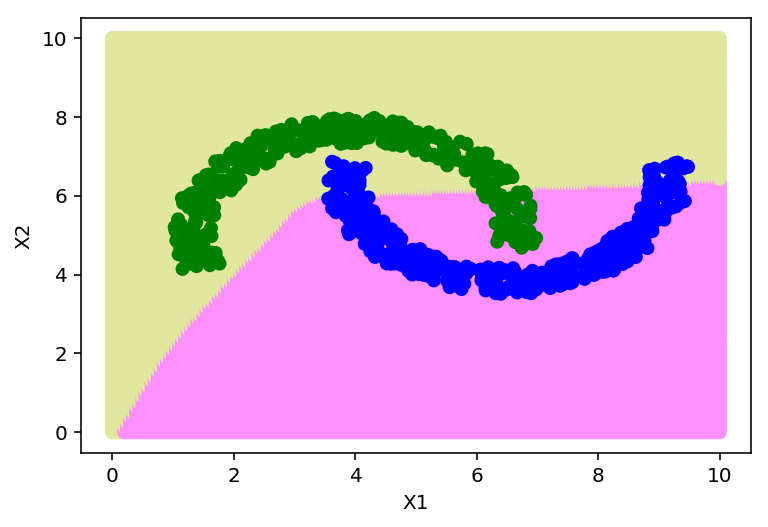

[[-0.16224182  0.68261909]
 [-0.16607061  0.84962434]
 [ 0.93368882 -0.10922936]
 [ 0.84069455 -0.17662382]
 [-0.51645827 -0.59474218]
 [-0.35147965  0.75756323]
 [-0.04278362 -0.67474878]
 [-0.63107967 -0.02531713]
 [-0.05177219  0.71188569]
 [-0.73435682  0.18134122]
 [ 0.12870786 -0.53687781]
 [ 0.38335779  0.6895982 ]
 [ 0.4815799   0.21324618]
 [ 0.76460356  0.26627657]
 [ 0.7935673  -0.17254755]
 [-0.71171337  0.36711481]
 [ 0.3596912   0.11364662]
 [-1.1168648   0.64887041]
 [-0.35389367 -0.3382701 ]
 [-0.21210292 -0.56151992]
 [-1.3615303   0.58745259]
 [-1.69697845  0.72909999]
 [-0.58601695 -0.08835709]
 [-0.31821966 -0.07772791]
 [ 0.62253475 -0.29725111]]


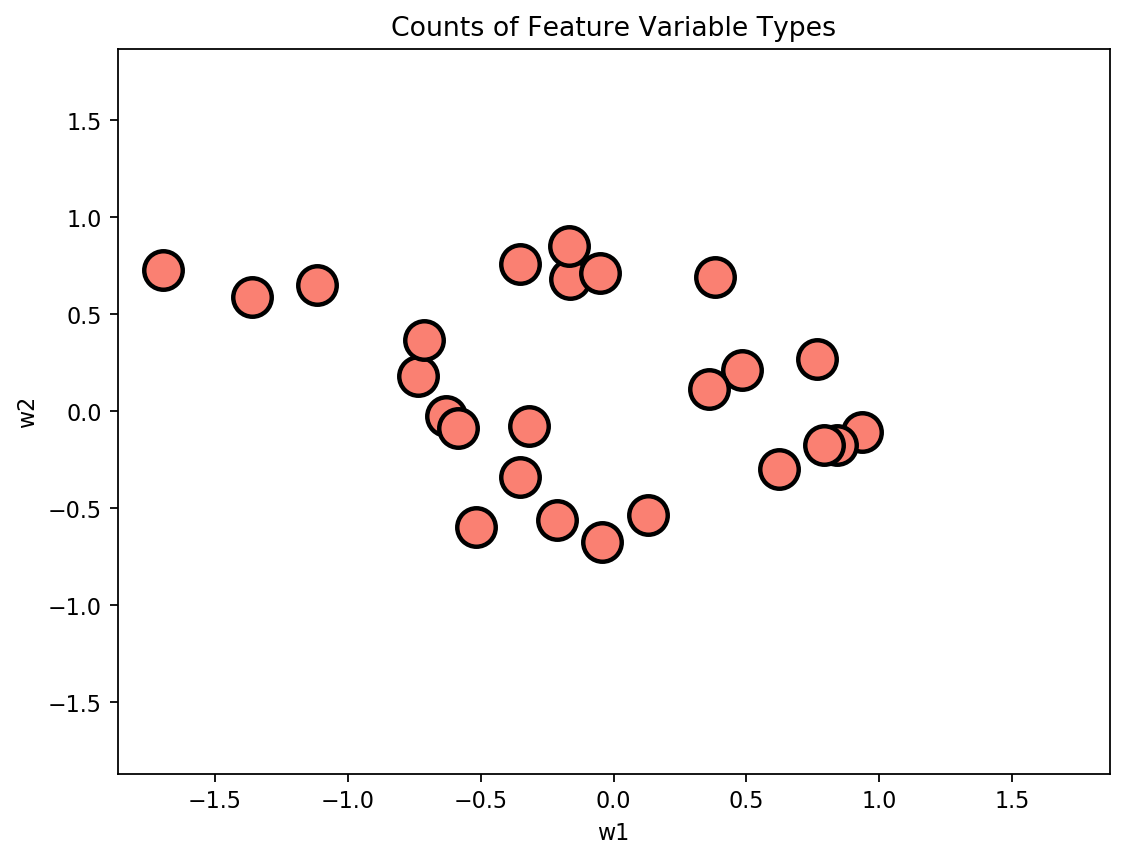

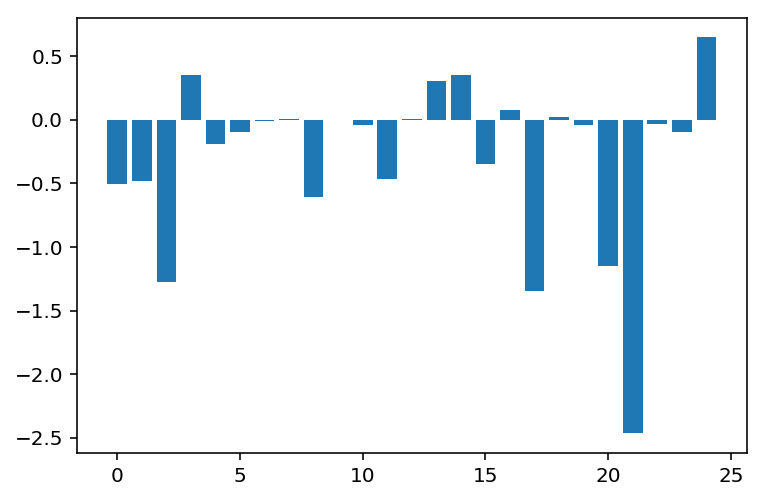

40000


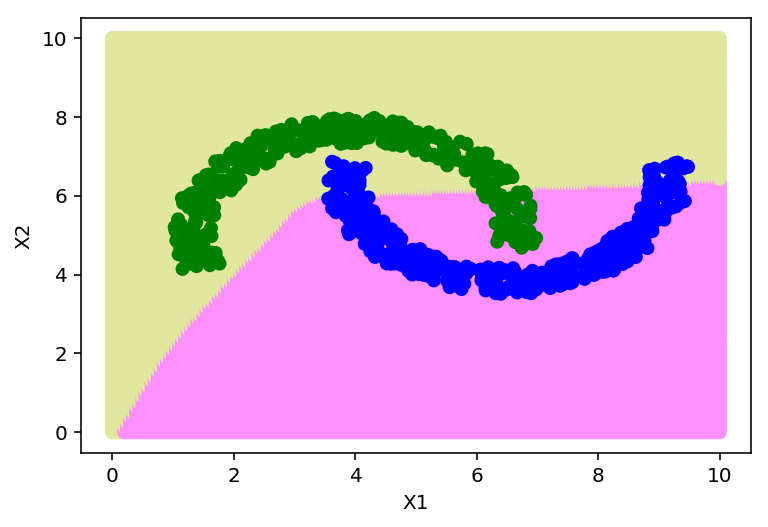

[[-0.16224182  0.68261909]
 [-0.16607061  0.84962434]
 [ 0.93368882 -0.10922936]
 [ 0.84069455 -0.17662382]
 [-0.51645827 -0.59474218]
 [-0.35147965  0.75756323]
 [-0.04278362 -0.67474878]
 [-0.63107967 -0.02531713]
 [-0.05177219  0.71188569]
 [-0.73435682  0.18134122]
 [ 0.12870786 -0.53687781]
 [ 0.38335779  0.6895982 ]
 [ 0.4815799   0.21324618]
 [ 0.76460356  0.26627657]
 [ 0.7935673  -0.17254755]
 [-0.71171337  0.36711481]
 [ 0.3596912   0.11364662]
 [-1.1168648   0.64887041]
 [-0.35389367 -0.3382701 ]
 [-0.21210292 -0.56151992]
 [-1.3615303   0.58745259]
 [-1.69697845  0.72909999]
 [-0.58601695 -0.08835709]
 [-0.31821966 -0.07772791]
 [ 0.62253475 -0.29725111]]


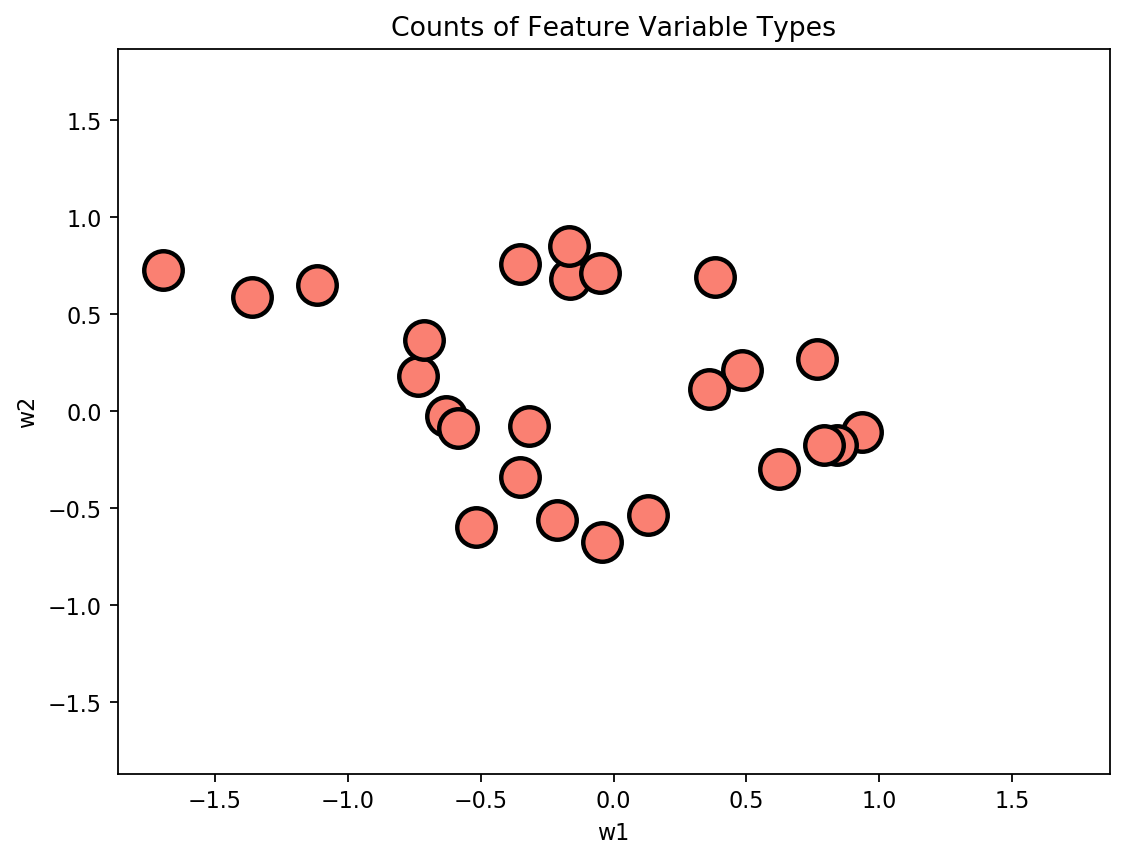

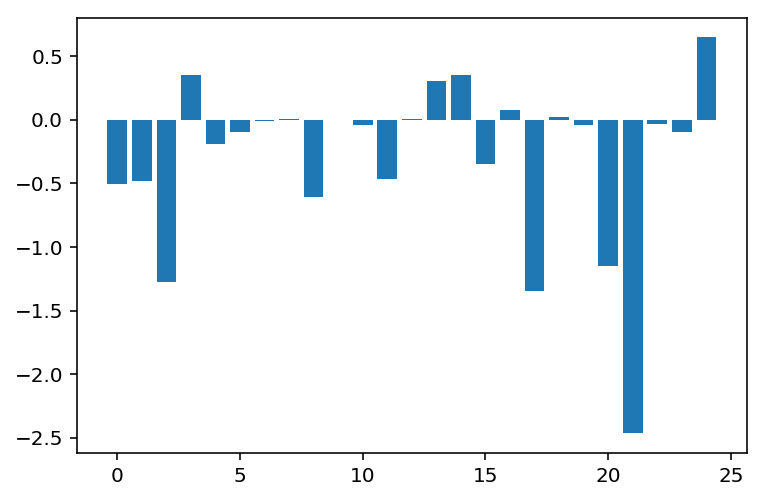

(25,)


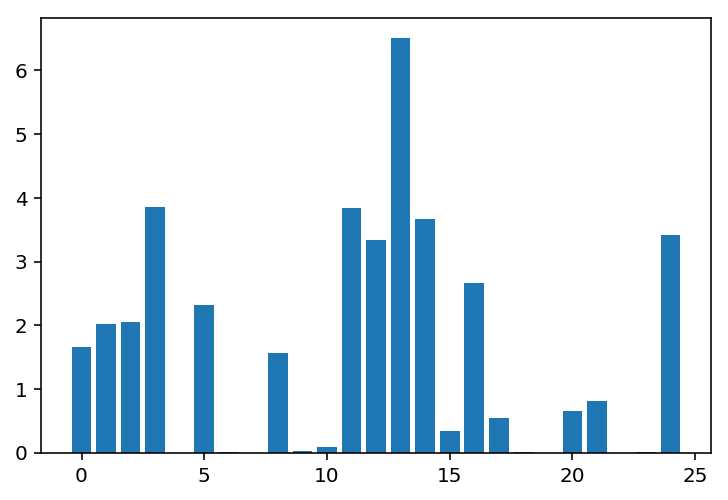

In [16]:
for ind in range(3):

    H = 25
    model = nn.Sequential(nn.Linear(d,H),
                         nn.ReLU(),
                         nn.Linear(H,1),
                          nn.Sigmoid())

    crit = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
    loss = train(x,y,model,crit)
    print("The loss is " + str(loss.tolist()))
    
        
    o = []

    def hook(module, input, output):
        o.append(output)
    
    model[1].register_forward_hook(hook)
    
    plot_regions(x,y,model)
    show_weights(model)
    a = np.array(o[0].tolist())
    t = np.sum(a, axis=0) / a.shape[0]
    
    
    plot_regions(x,y,model)
    show_weights(model)
    show_layer(t)


## Data Set 3

---------------------------------------------------------------
The loss is 0.0017981822602450848
40000


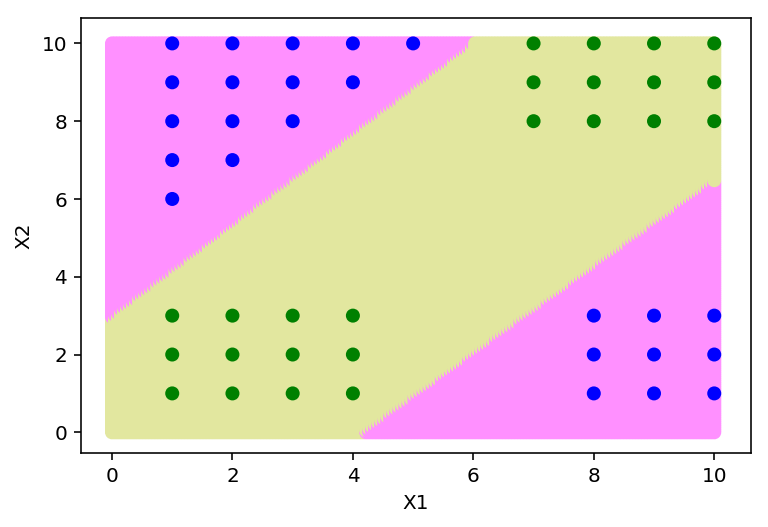

[[ 0.64169854 -0.33649006]
 [-2.67624712  2.51107502]
 [-0.64586008  0.10407148]
 [-0.61863601  0.05964096]
 [ 1.88245475 -1.54371262]]


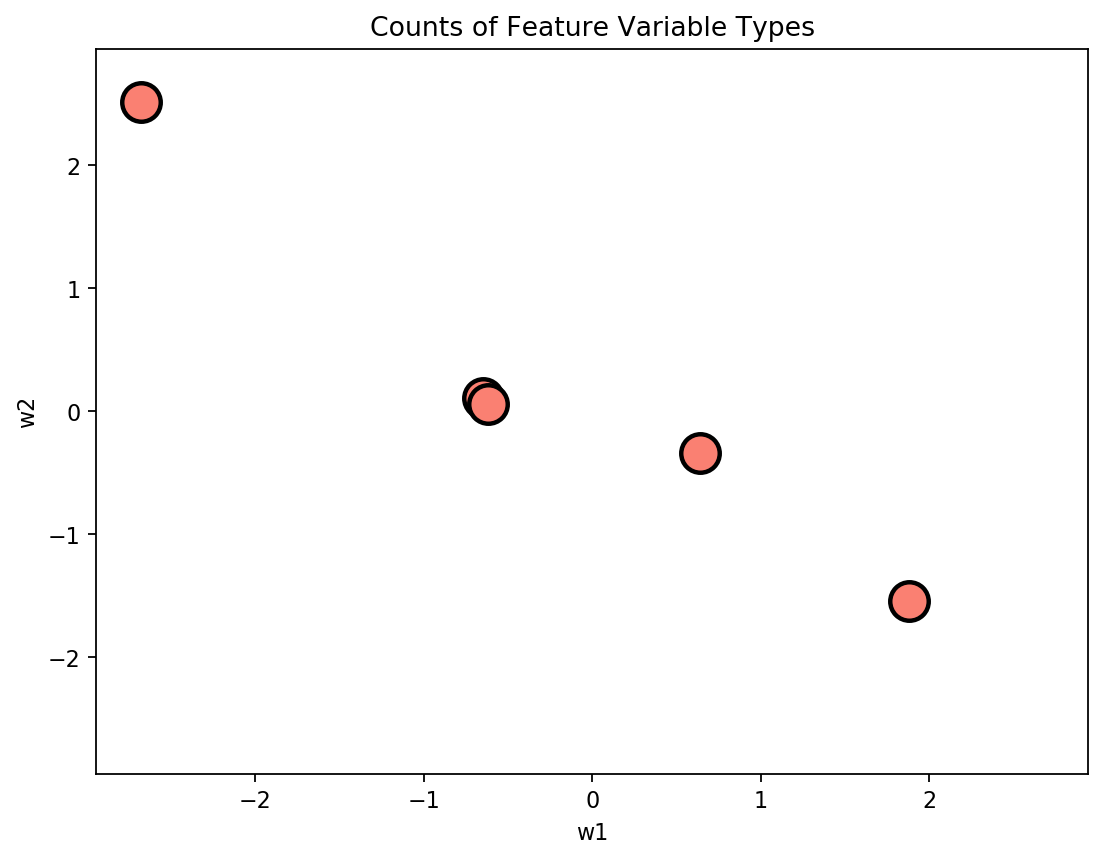

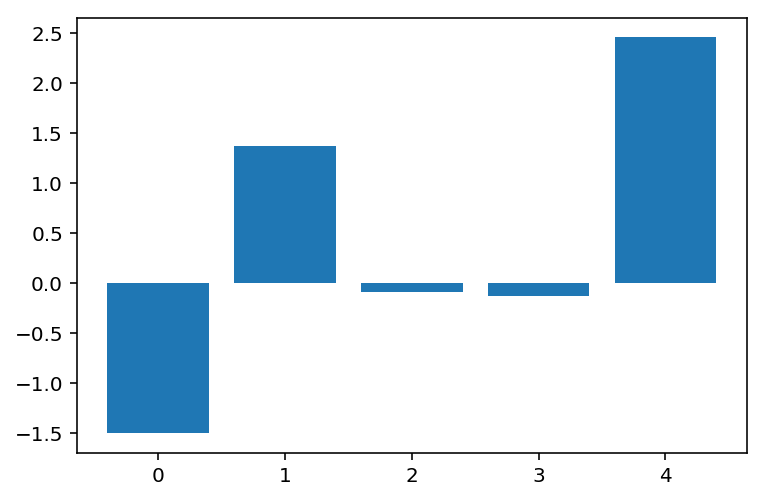

(5,)


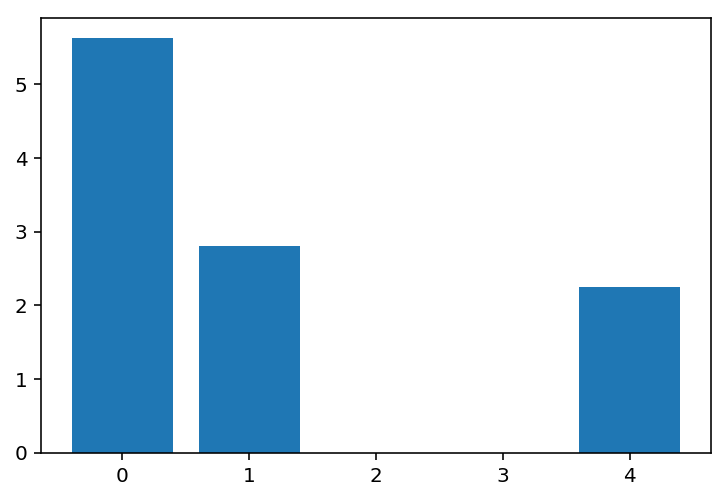

---------------------------------------------------------------
---------------------------------------------------------------
The loss is 0.002029282273724675
40000


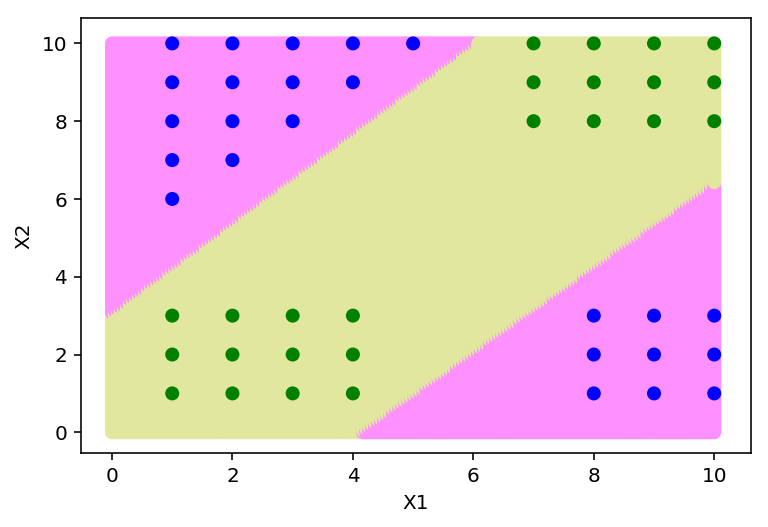

[[ 2.42561078 -1.97787201]
 [-1.17274475  1.27578175]
 [-0.37036729 -0.70453596]
 [ 1.26808619 -0.97436553]
 [ 0.6811977  -0.21380608]]


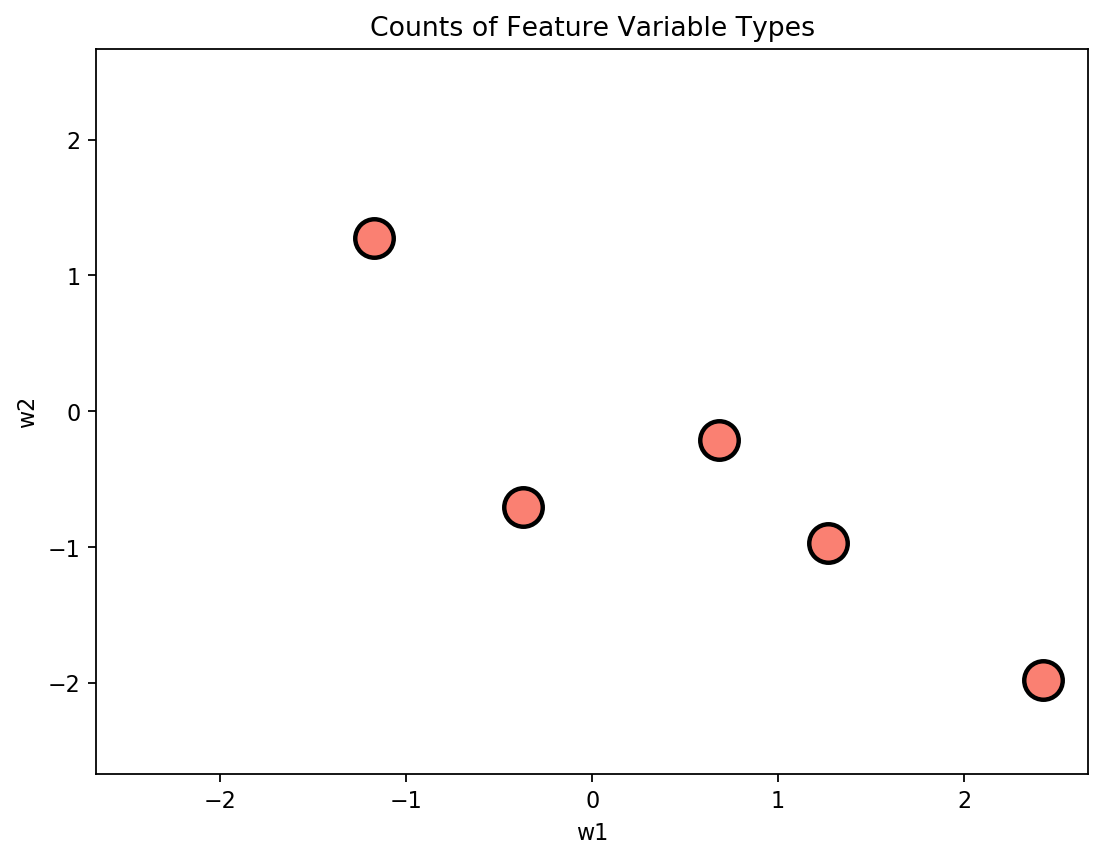

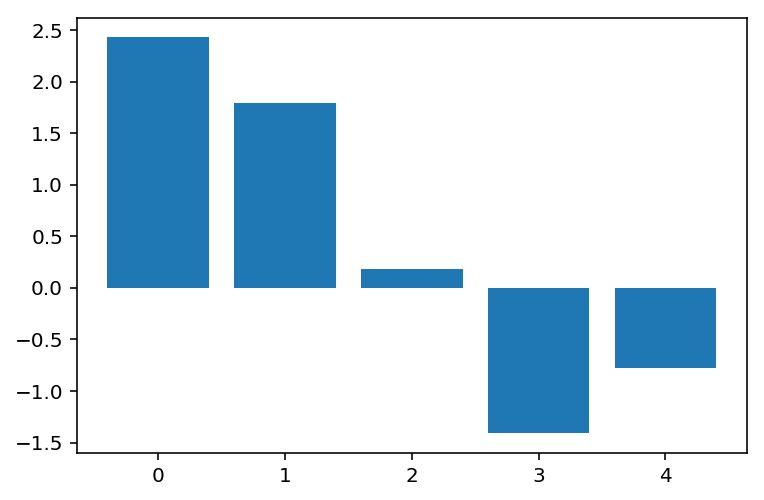

(5,)


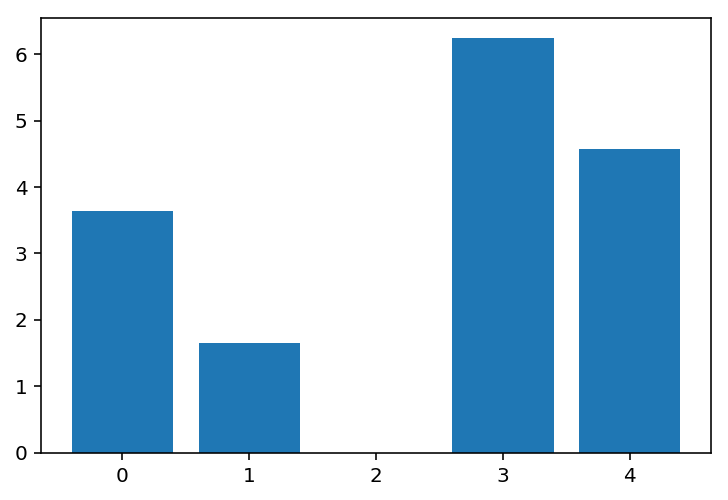

---------------------------------------------------------------
---------------------------------------------------------------
The loss is 0.008906625211238861
40000


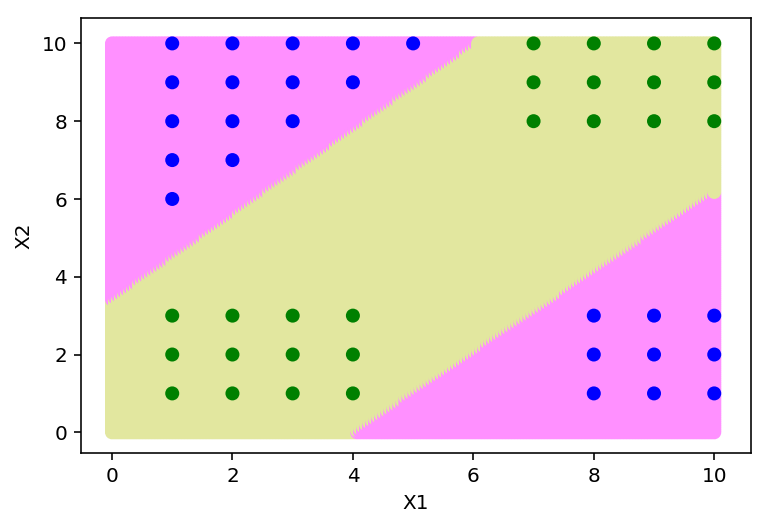

[[-1.11808729  1.0774107 ]
 [ 0.02822135 -0.51487279]
 [-1.70353699  1.65814912]
 [-2.81194925  2.54856157]
 [-0.4715541   0.03866795]]


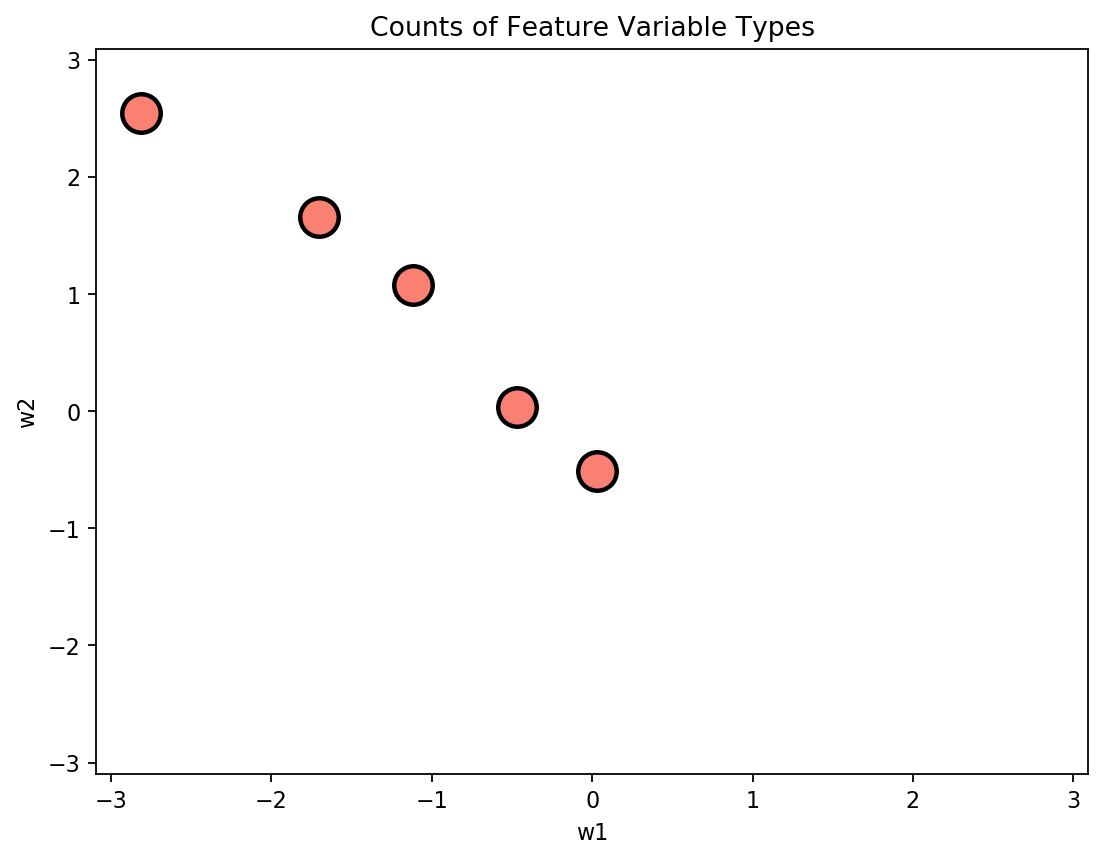

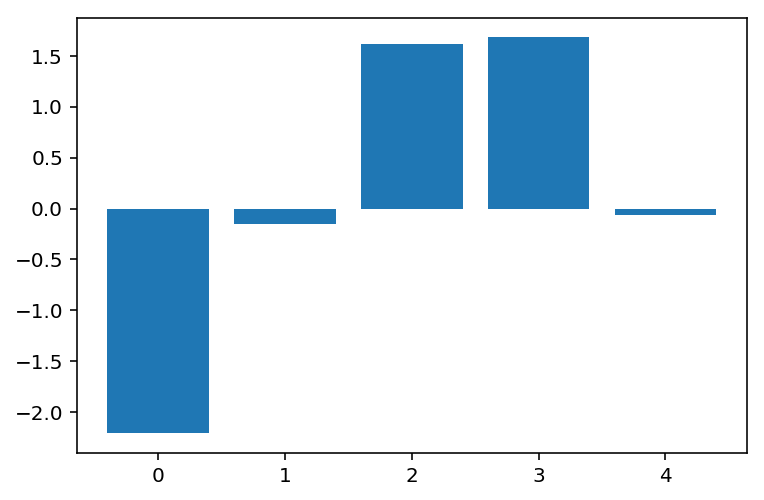

(5,)


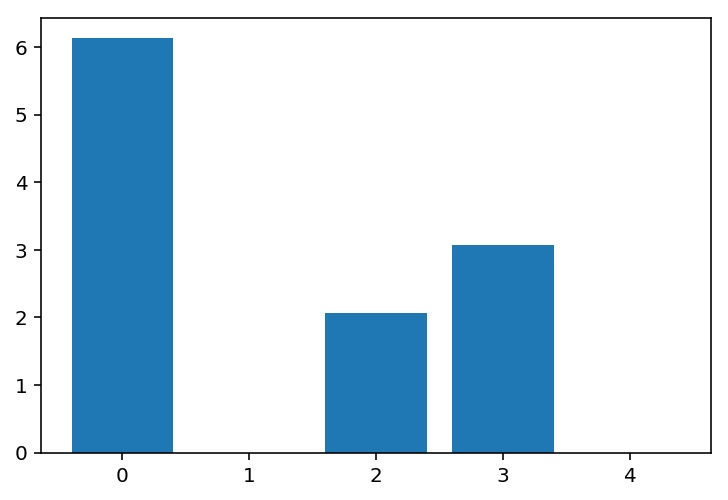

---------------------------------------------------------------


In [17]:

x,y = load_data('data0.txt')
x = torch.FloatTensor(x)
y = torch.FloatTensor(y)
for ind in range(3):
    print('---------------------------------------------------------------')
    H = 5
    model = nn.Sequential(nn.Linear(d,H),
                         nn.ReLU(),
                         nn.Linear(H,1),
                          nn.Sigmoid())

    crit = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
    loss = train(x,y,model,crit)
    print("The loss is " + str(loss.tolist()))
           
    o = []

    def hook(module, input, output):
        o.append(output)
    
    model[1].register_forward_hook(hook)
    
    plot_regions(x,y,model)
    show_weights(model)
    a = np.array(o[0].tolist())
    t = np.sum(a, axis=0) / a.shape[0]
    
    
    
    
    #plot_regions(x,y,model)
    #show_weights(model)
    show_layer(t)
    print('---------------------------------------------------------------')

## Data Set 4

The loss is 0.4029763340950012
40000


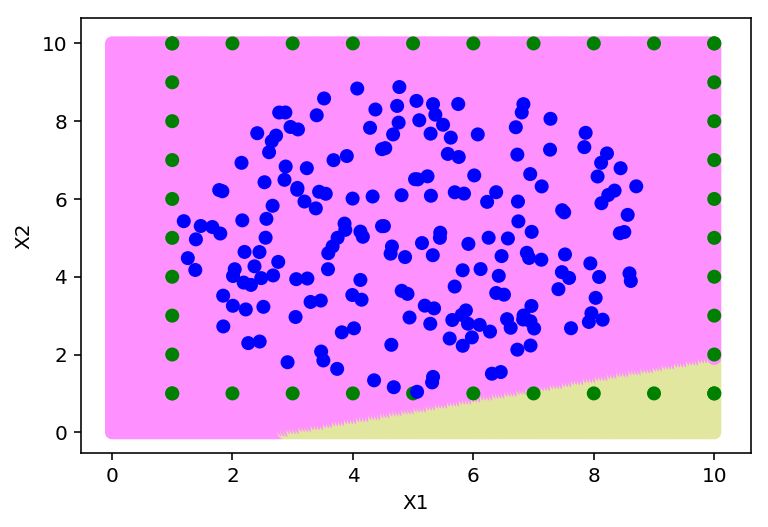

[[ 0.48497859 -0.83315349]
 [-0.38952935 -0.57481623]
 [ 0.42099112 -0.6838963 ]
 [ 0.71717763  0.54504144]
 [-0.02057313  0.32584381]]


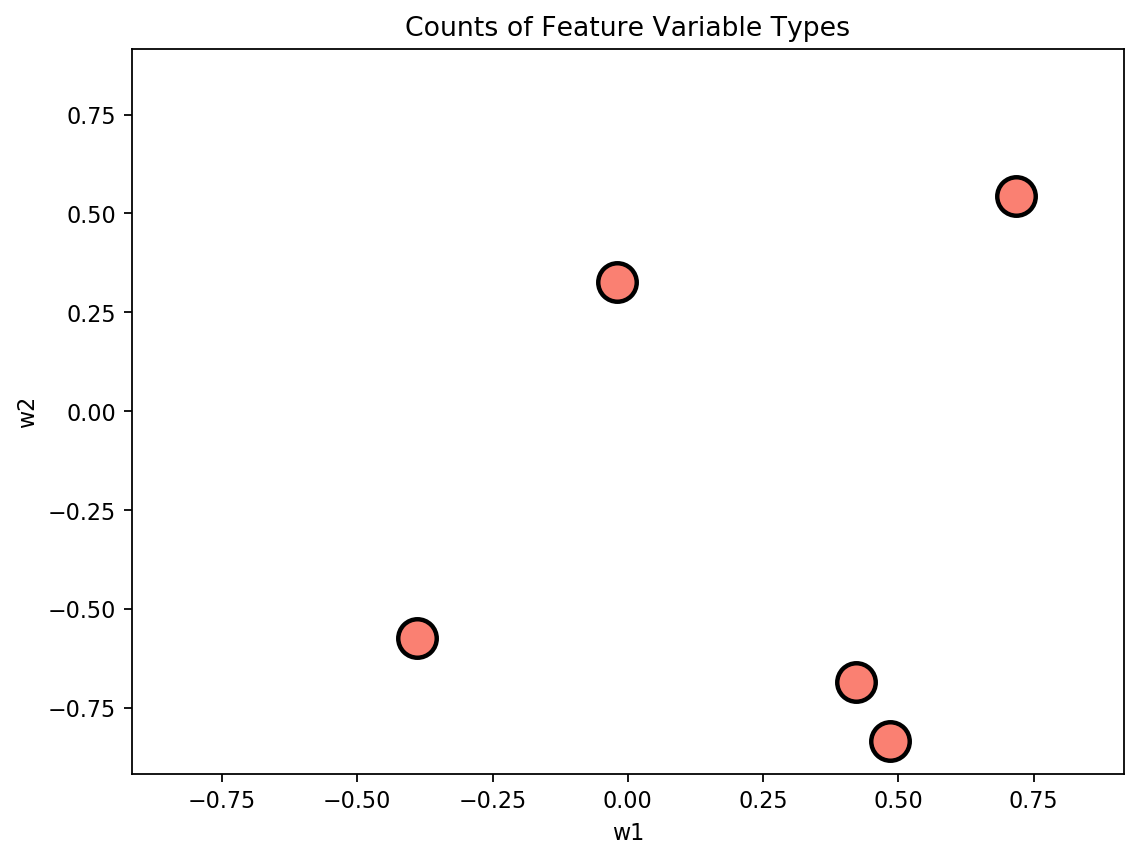

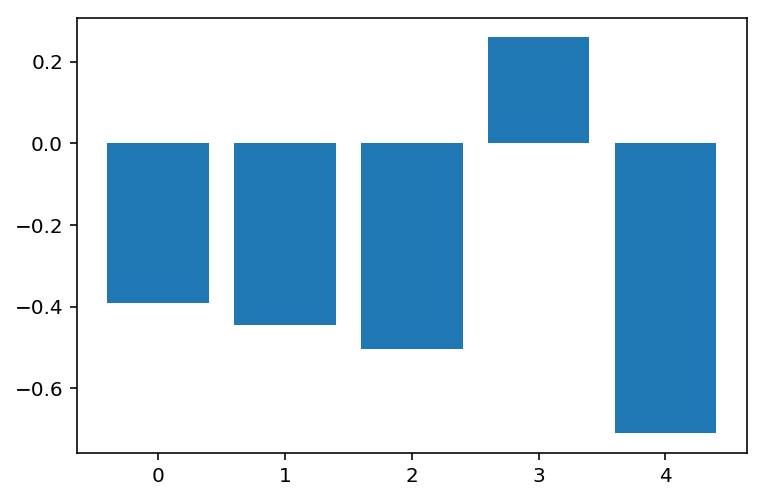

40000


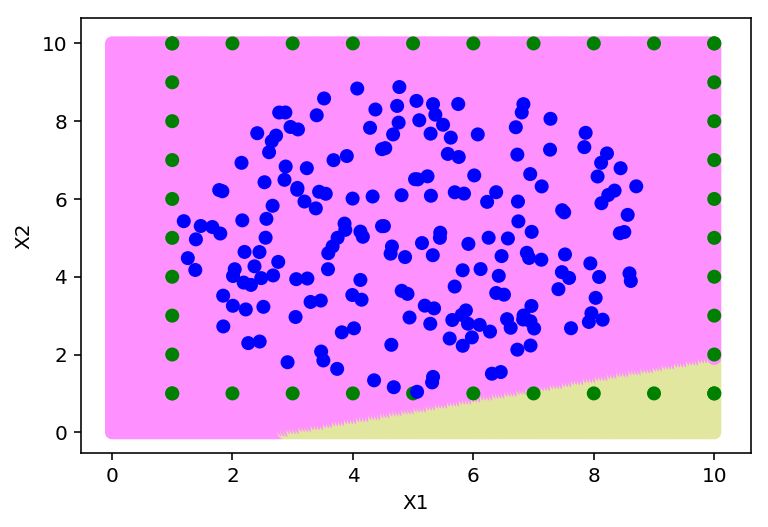

[[ 0.48497859 -0.83315349]
 [-0.38952935 -0.57481623]
 [ 0.42099112 -0.6838963 ]
 [ 0.71717763  0.54504144]
 [-0.02057313  0.32584381]]


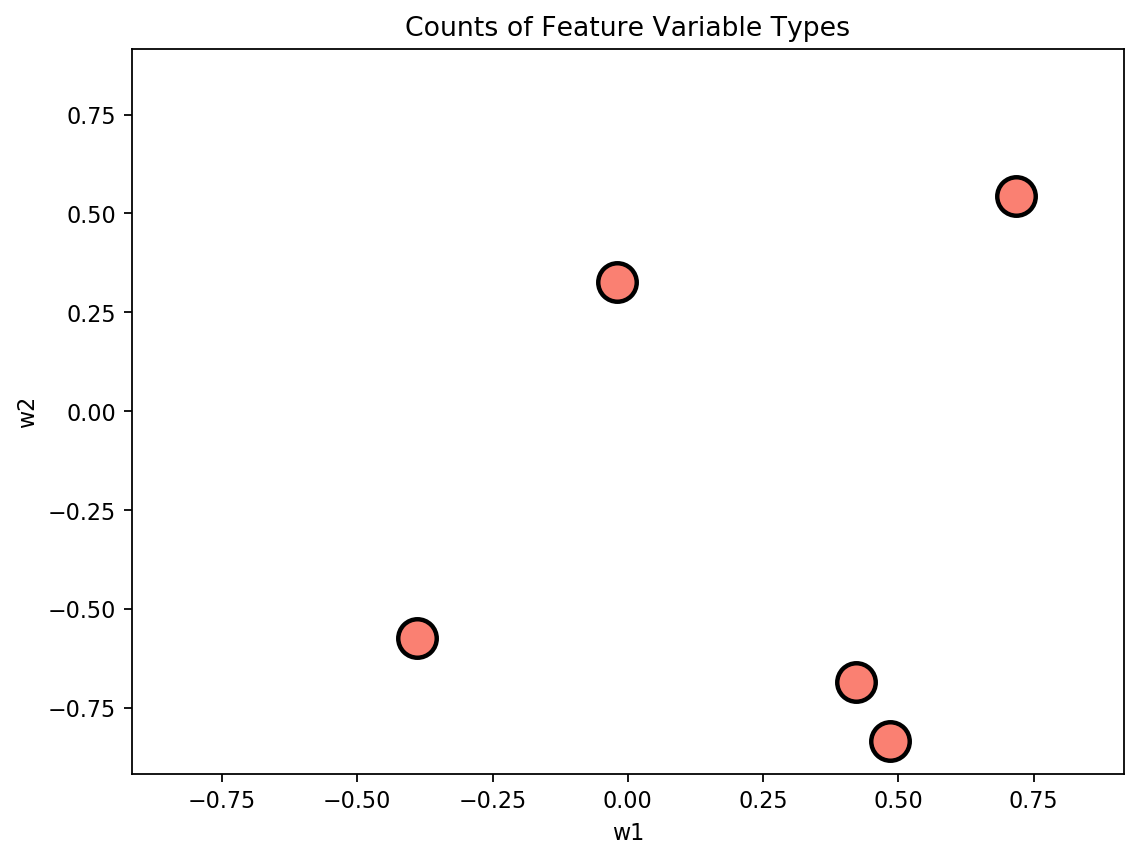

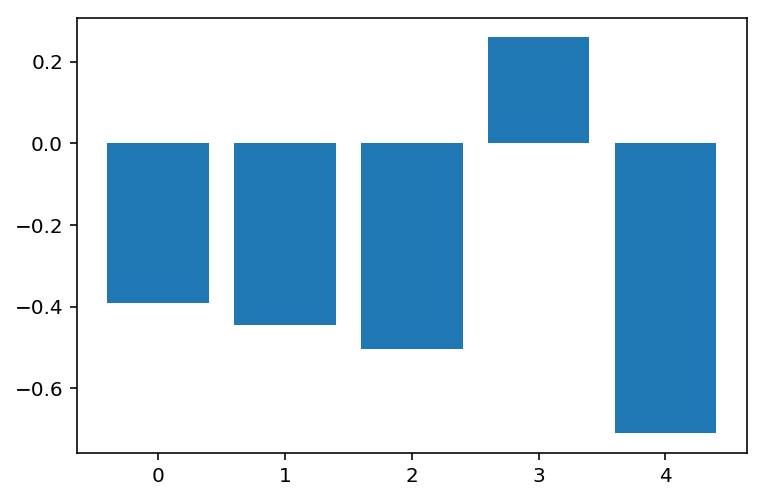

(5,)


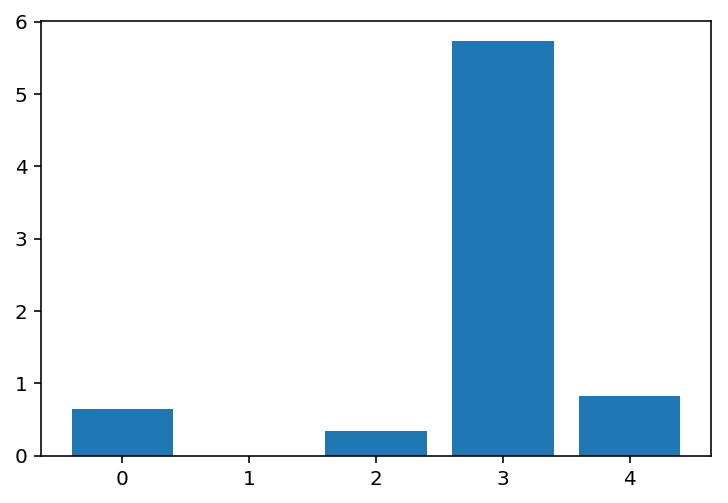

---------------------------------------------------------------
The loss is 0.480346143245697
40000


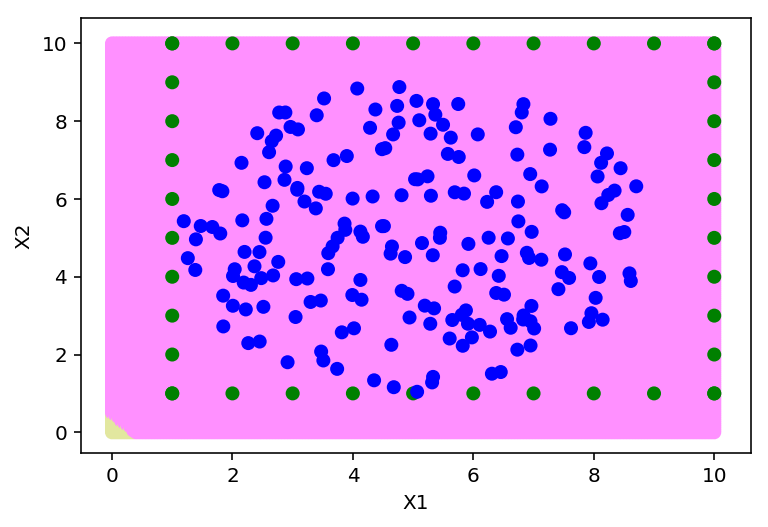

[[-0.57591242 -0.2620669 ]
 [-0.07158568  0.21050341]
 [ 0.0980557   0.4078061 ]
 [ 0.03798234 -0.29936188]
 [ 0.35784423  0.46119291]]


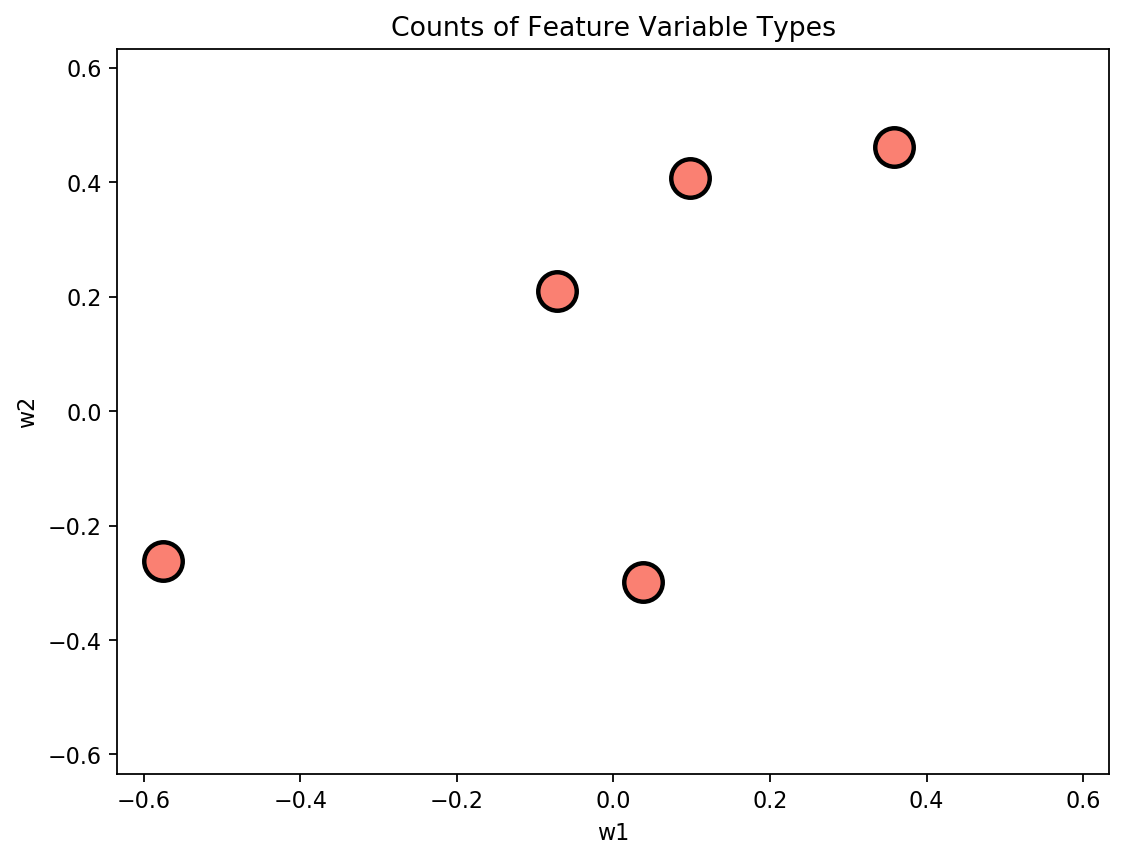

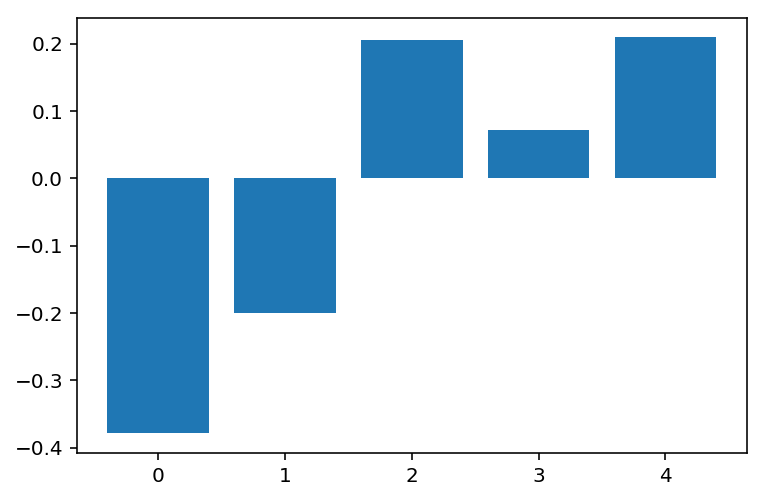

40000


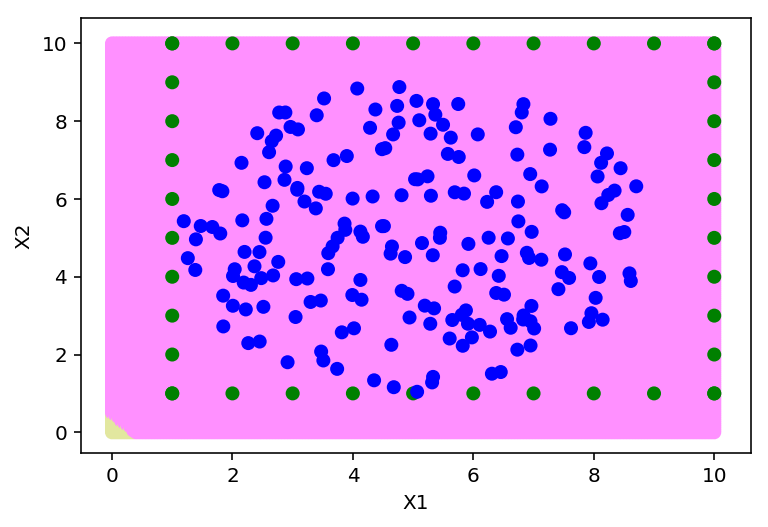

[[-0.57591242 -0.2620669 ]
 [-0.07158568  0.21050341]
 [ 0.0980557   0.4078061 ]
 [ 0.03798234 -0.29936188]
 [ 0.35784423  0.46119291]]


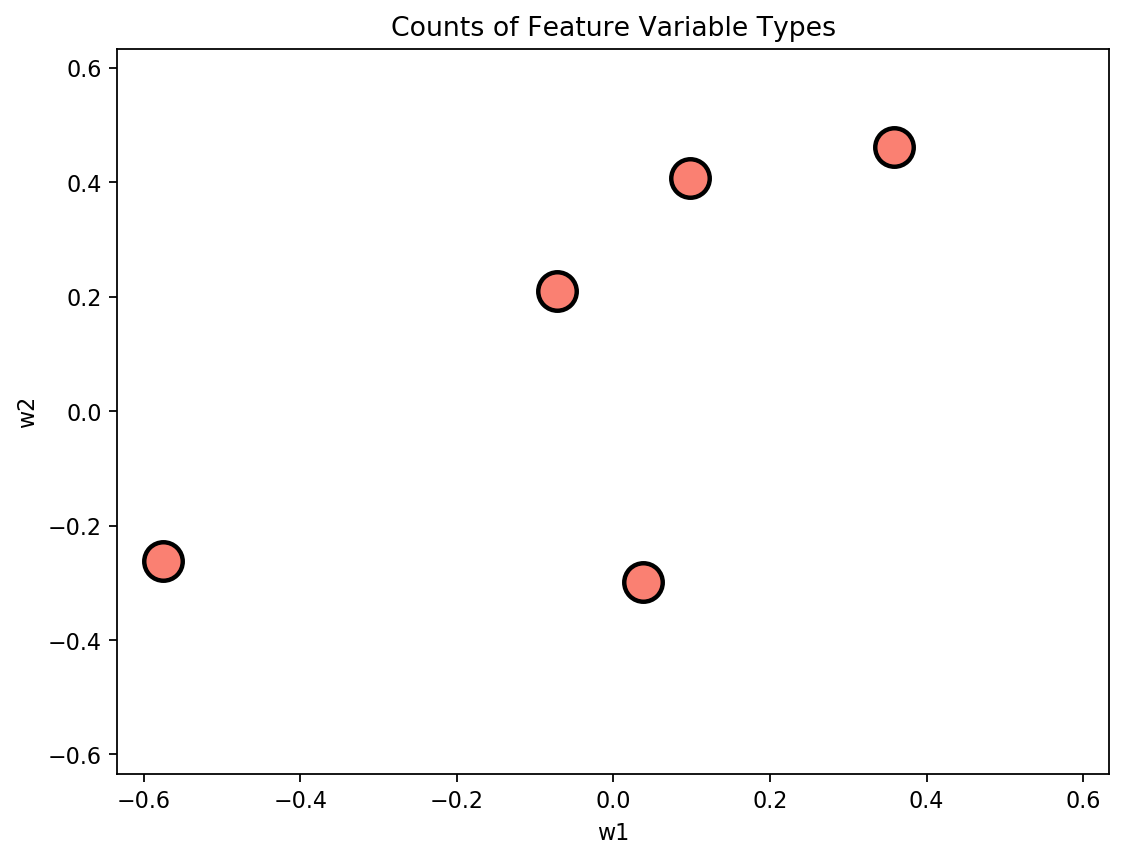

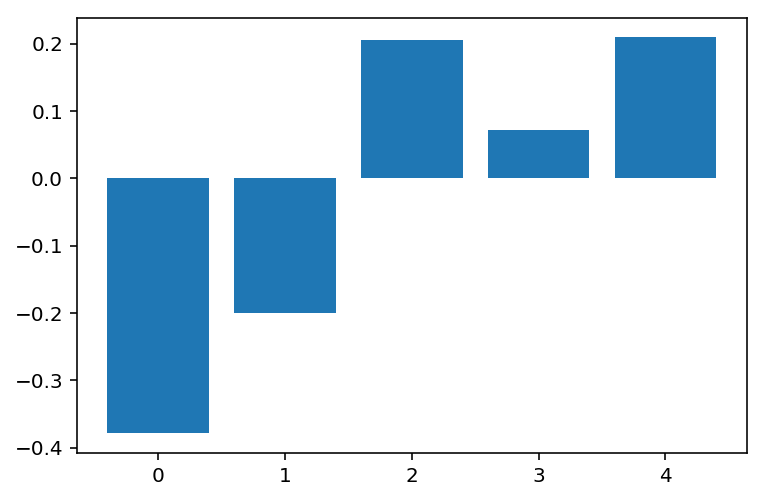

(5,)


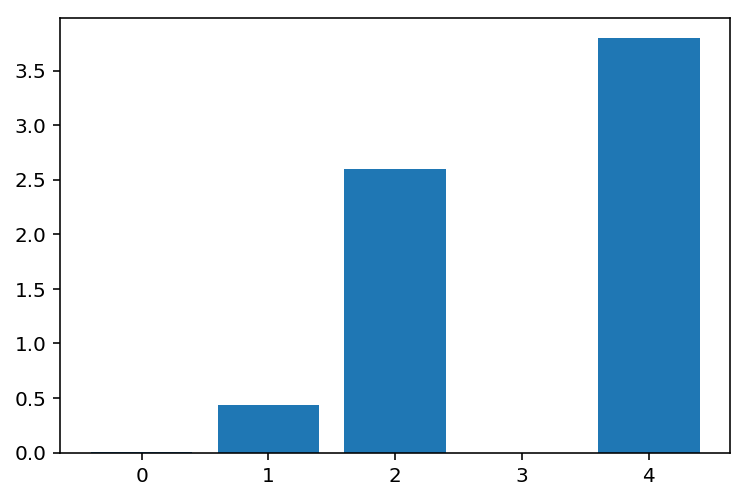

---------------------------------------------------------------
The loss is 0.46465402841567993
40000


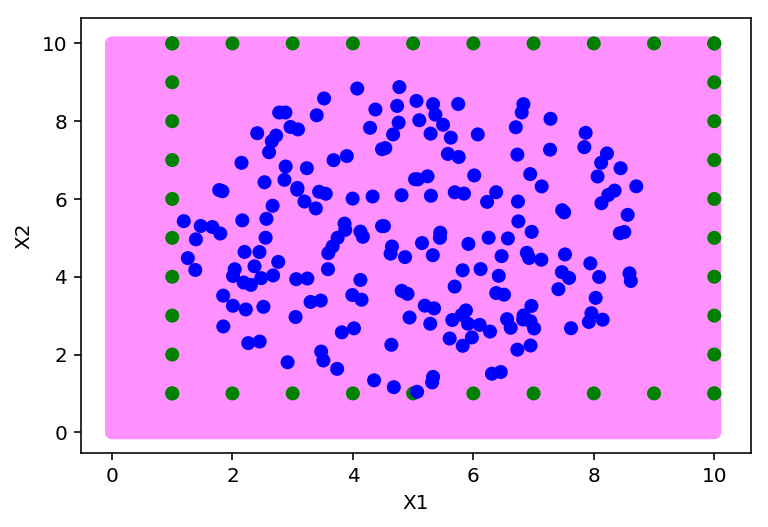

[[-0.13693106 -0.14169222]
 [ 0.32900408  0.50947082]
 [-0.09758663 -0.50611705]
 [-0.1878438  -0.55149555]
 [ 0.49465251  0.73488724]]


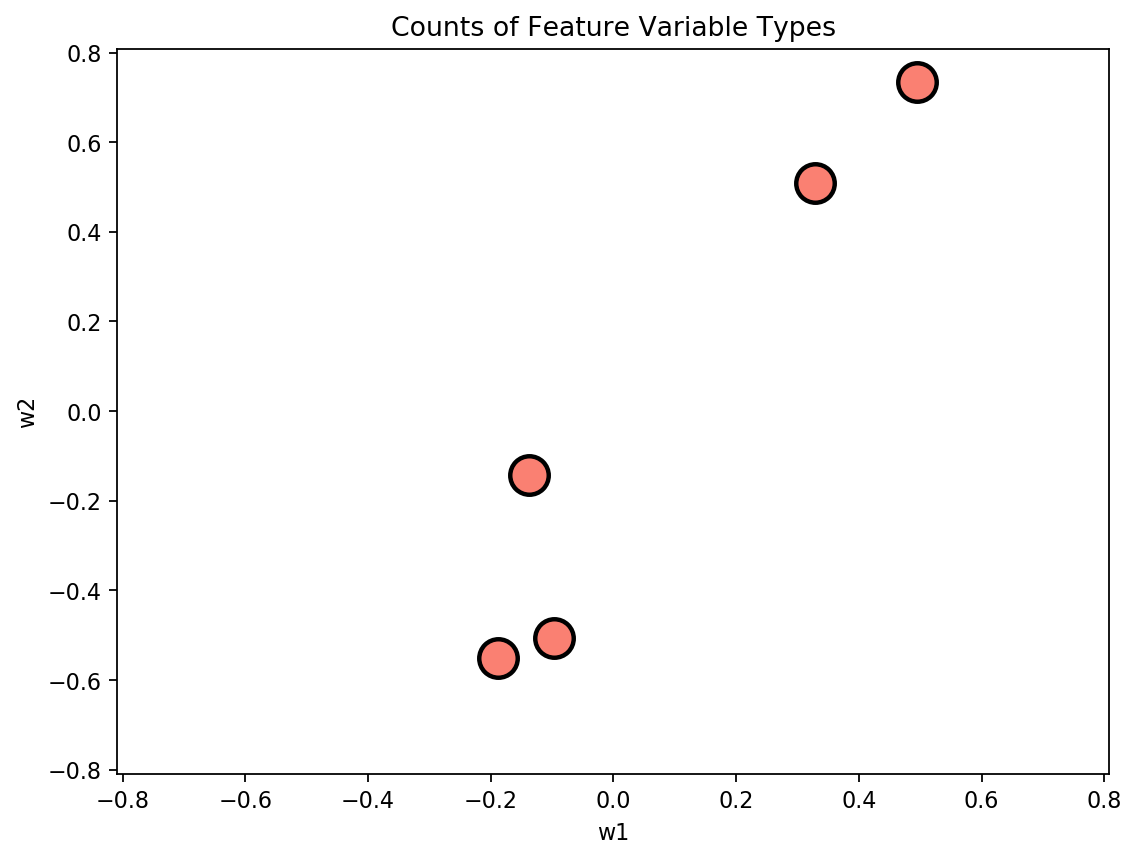

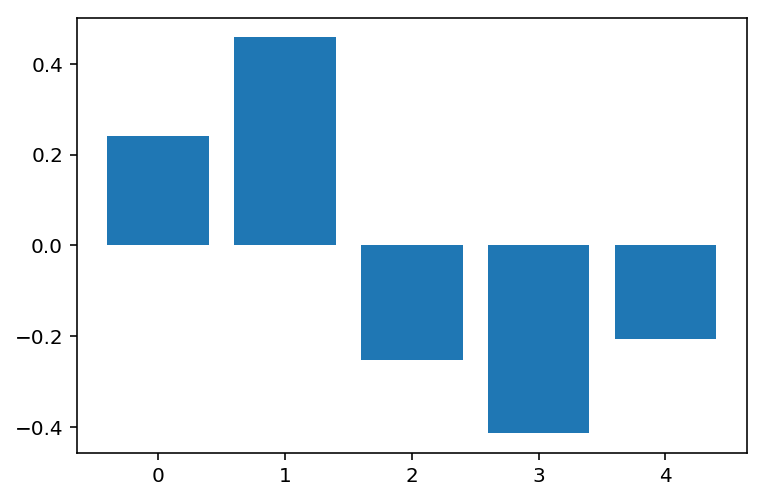

40000


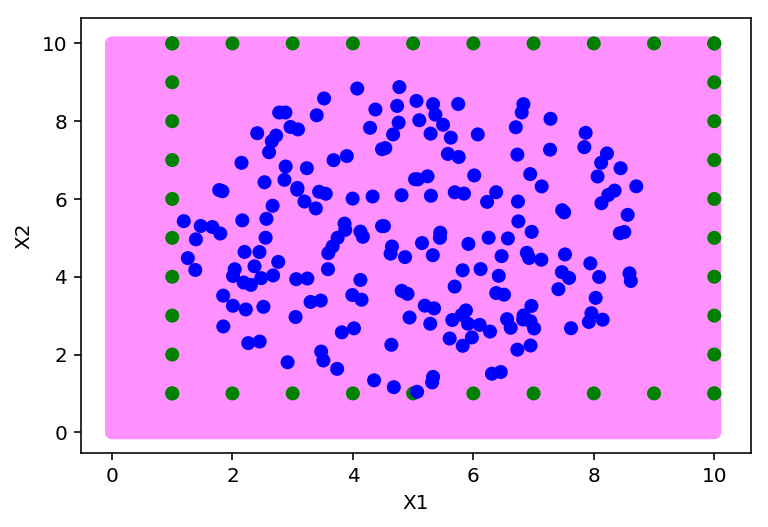

[[-0.13693106 -0.14169222]
 [ 0.32900408  0.50947082]
 [-0.09758663 -0.50611705]
 [-0.1878438  -0.55149555]
 [ 0.49465251  0.73488724]]


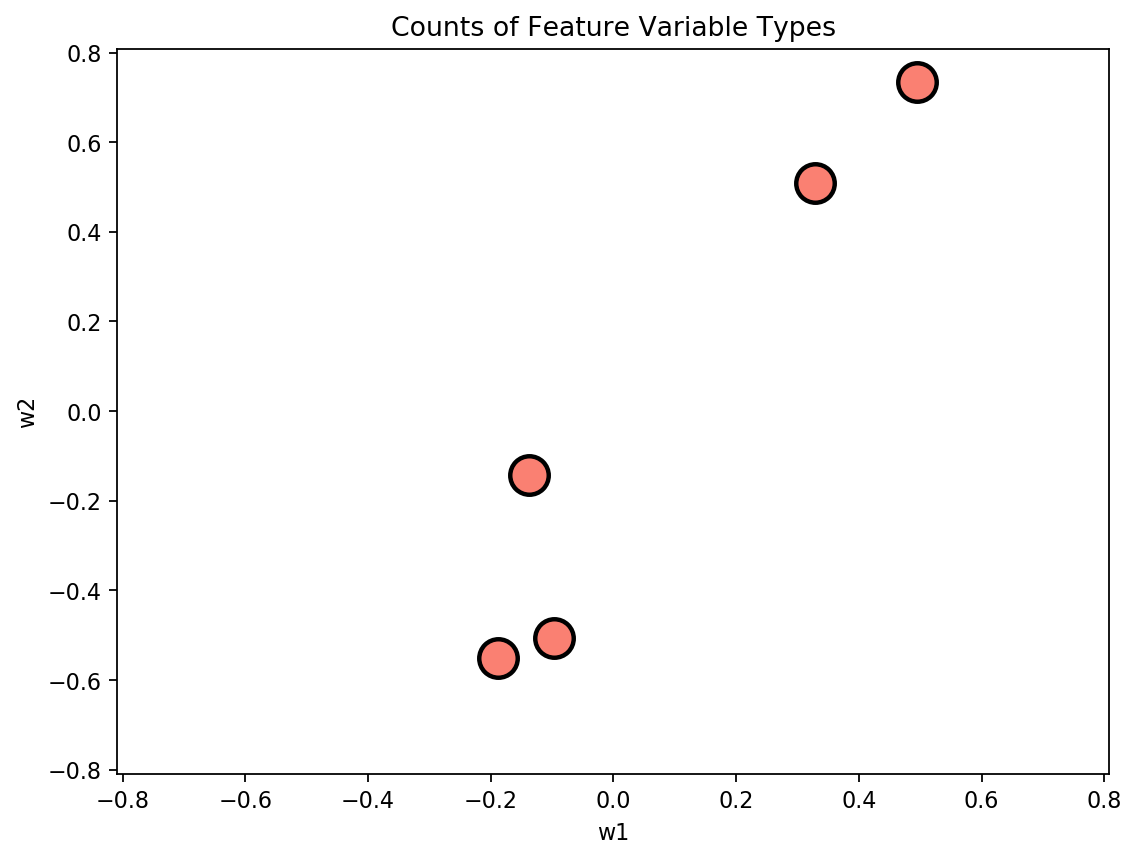

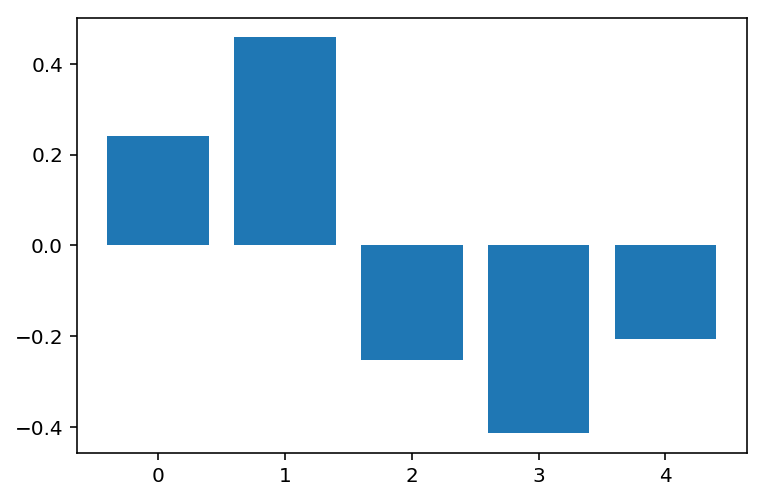

(5,)


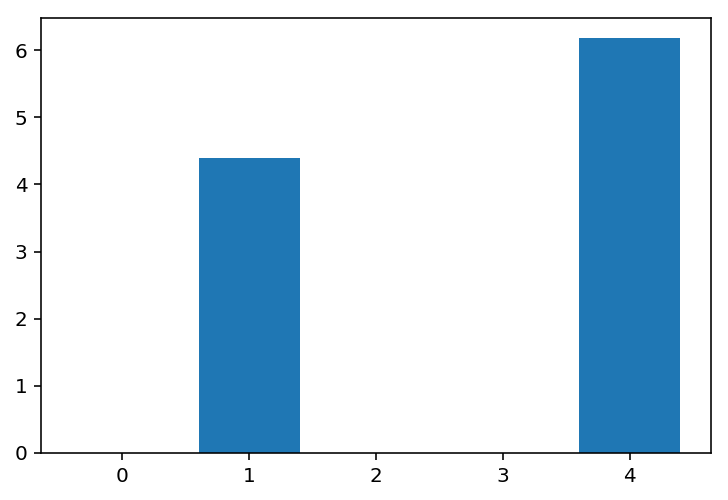

---------------------------------------------------------------


In [18]:
#get data for new model
x1 = []
for z in range(1,11):
    x1.append([z,1])
    x1.append((1,z))
    x1.append((10,z))
    x1.append((z,10))
y1 = [[0] for x in range(len(x1))]
x2 = []
y2 = []
for z in range(200):
    r = 4 * (random.random() ** 0.5)
    theta = random.random() * 2 * 3.14159
    x = 5 + r * cos(theta)
    y = 5 + r * sin(theta)
    x2.append([x,y])
    y2.append([1])

x = x1 + x2
y = y1 + y2





x = torch.FloatTensor(x)
y = torch.FloatTensor(y)
for ind in range(3):

    H = 5
    model = nn.Sequential(nn.Linear(d,H),
                         nn.ReLU(),
                         nn.Linear(H,1),
                          nn.Sigmoid())

    crit = torch.nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(),lr=0.01)
    loss = train(x,y,model,crit)
    print("The loss is " + str(loss.tolist()))
    
             
    o = []

    def hook(module, input, output):
        o.append(output)
    
    model[1].register_forward_hook(hook)
    
    plot_regions(x,y,model)
    show_weights(model)
    a = np.array(o[0].tolist())
    t = np.sum(a, axis=0) / a.shape[0]
    
    

    plot_regions(x,y,model)
    show_weights(model)
    
    
    #plot_regions(x,y,model)
    #show_weights(model)
    show_layer(t)
    print('---------------------------------------------------------------')
    